In [79]:
pwd

'/user/vpalline'

In [80]:
!which python

/projects/academic/courses/cse546s23/vpalline/anaconda3/bin/python


In [81]:
#Importing all the required packages
import gymnasium as gym
import gym
import copy
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from gym import spaces
from operator import add
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pickle

In [82]:
#GridWorld Game - Environment Definition
grid_world = np.zeros((5,5))
grid_world_size = (5,5)
print("GridWorld Game Size:",grid_world_size[0],"x",grid_world_size[1])

#GridWorld Game - Agent(Mario) Action Set Definition
action_space = ["Up","Down","Right","Left"]
print("GridWorld Game Set of Actions:", *action_space, sep=', ')


state_space=np.array([20,15,10,5,0,21,16,11,6,1,22,17,12,7,2,23,18,13,8,3,24,19,14,9,4]).reshape(5,5)
print("GridWorld Game Set of States:"+str(state_space))


GridWorld Game Size: 5 x 5
GridWorld Game Set of Actions:, Up, Down, Right, Left
GridWorld Game Set of States:[[20 15 10  5  0]
 [21 16 11  6  1]
 [22 17 12  7  2]
 [23 18 13  8  3]
 [24 19 14  9  4]]


## **PART 1 & 2**

## **1. DETERMINISTIC ENVIRONMENT**

In [83]:
class Mario_Game_Deterministic_Environment(gym.Env):
    def __init__(self, max_timeSteps):
        #GridWorld Game - Observation space Definition( no. of rows * columns)
        self.observation_space = spaces.Discrete(25)
        #GridWorld Game - Setting the maximum no. of steps agent can take
        self.max_timeSteps = 16
        
            
    def reset(self):

        #GridWorld Game - Agent's Initial Position
        self.agent_pos = np.array([0, 4])
        #GridWorld Game - Agent's EndGoal Position
        self.end_goal_pos = np.array([2,2])

        #GridWorld Game - Positions of Gold_Chest (+ Reward)
        self.gold_chest_pos= np.array([[0,1],[1,3],[3,4],[4,1]])
        #GridWorld Game - Positions of Food (+ Reward)
        self.Food_pos = np.array([[2,3],[1,0],[4,3]])
        #GridWorld Game - Positions of devils (- Reward)
        self.devil_pos = np.array([[2,0],[0,2]])
        #GridWorld Game - Positions of dragons (- Reward)
        self.dragon_pos = np.array([[2,4],[4,0]])

        #GridWorld Game - Setting initial values for rewards, cumulative_rewards,timesteps
        self.rewards = 0      
        self.cumulative_rewards = 0
        self.timeStep = 0
        self.state = np.zeros(grid_world_size)
        self.done = False
        #print("After Resetting Agent Position:")
        #print(self.agent_pos)
        return
    
    def step(self, action):
        previous_pos = self.agent_pos.copy()
        if action == 0:
            #Action = Left
            self.agent_pos[0] -= 1
        if action == 1:
            #Action = Right
            self.agent_pos[0] += 1
        if action == 2:
            #Action = Up
            self.agent_pos[1] += 1
        if action == 3:
            #Action = Down
            self.agent_pos[1] -= 1
        
        #To ensure the Agent is within the 5x5 grid limits - clip function
        self.agent_pos = np.clip(self.agent_pos, 0, 4)
        self.state = np.zeros(grid_world_size)
        
        #GridWorld Game Rewards Configuration and Unconfiguration once the rewards are collected
        reward = 1
        #Reward for Previous Position
        if np.all(self.agent_pos == previous_pos):
            reward = -1
        #Reward for End Goal Position
        if (self.agent_pos == self.end_goal_pos).all():
            reward = 50
            self.done = True
            self.rewards += 1
        #Positive Reward for Gold Chest Position
        if (np.any(np.all(self.agent_pos == self.gold_chest_pos, axis=1))):
            reward = 10
            for index in range(len(self.gold_chest_pos)):
                if (self.gold_chest_pos[index]==self.agent_pos).all():
                    self.gold_chest_pos = np.delete(self.gold_chest_pos, index, axis=0)
                    self.rewards += 1
                    break
        #Positive Reward for Food Position
        if (np.any(np.all(self.agent_pos == self.Food_pos, axis=1))):
            reward = 25
            for index in range(len(self.Food_pos)):
                if (self.Food_pos[index]==self.agent_pos).all():
                    self.Food_pos = np.delete(self.Food_pos, index, axis=0)
                    self.rewards += 1
                    break
        #Negative Reward for Devil Position
        if (np.any(np.all(self.agent_pos == self.devil_pos, axis=1))):
            reward = -5
            for index in range(len(self.devil_pos)):
                if (self.devil_pos[index]==self.agent_pos).all():
                    self.devil_pos = np.delete(self.devil_pos, index, axis=0)
                    break
        #Negative Reward for Dragon Position
        if (np.any(np.all(self.agent_pos == self.dragon_pos, axis=1))):
            reward = -10
            for index in range(len(self.dragon_pos)):
                if (self.dragon_pos[index]==self.agent_pos).all():
                    self.dragon_pos = np.delete(self.dragon_pos, index, axis=0)
                    break 

        #Calculating the cummulative rewards until the current timestep
        self.cumulative_rewards += reward
        self.timeStep += 1

        #Checking if we reached Goal Position or reached the maximum timesteps allowed
        if not self.done:
            self.done = True if self.timeStep >= self.max_timeSteps else False

        #Storing the Agent's  Current Position and Reward , Cummulative Rewards
        info = "Current Agent Position: [" + str(self.agent_pos[0]) + "," + str(self.agent_pos[1]) + "] ; " + "Current State Reward: " + str(reward) + " ; " + "Total Cumulative Reward: " + str(self.cumulative_rewards)
        #print(info)
        return self.agent_pos,reward, self.done, info
    
    def render(self):
        #Plot size
        fig,ax = plt.subplots(figsize=(7.5,7.5),facecolor="white")
        ax.set_xlim(0,5)
        ax.set_ylim(0,5)
        plt.grid()
        ax.set_facecolor("black")
        agent1_pos,goal1_pos = False,False
        plt.xticks([0,1,2,3,4,5])
        plt.yticks([0,1,2,3,4,5])

        if not agent1_pos:
            #For Agent's Visualization
            agent = AnnotationBbox(OffsetImage(plt.imread('agent.png'), zoom=0.2), list(map(add, self.agent_pos , [0.3, 0.4])), frameon=True)
            ax.add_artist(agent)

        if not goal1_pos:
            #For End Goal Visulaization
            goal = AnnotationBbox(OffsetImage(plt.imread('goal_pos.png'), zoom=0.087), list(map(add, self.end_goal_pos , [0.5, 0.4])), frameon=False)
            ax.add_artist(goal)

        for Food1_pos in self.Food_pos:
            #For Mushrooom Food State Visualization
            Food = AnnotationBbox(OffsetImage(plt.imread('Food.png'), zoom=0.098), list(map(add, Food1_pos, [0.68, 0.68])), frameon=False)
            ax.add_artist(Food)

        for gold1_chest_pos in self.gold_chest_pos:
            #For Gold Chest State Visulaization
            gold = AnnotationBbox(OffsetImage(plt.imread('gold_chest.png'), zoom=0.175), list(map(add, gold1_chest_pos, [0.7, 0.7])), frameon=False)
            ax.add_artist(gold)

        for devil1_pos in self.devil_pos:
            #For Devil state Visualization
            devil = AnnotationBbox(OffsetImage(plt.imread('Devil.png'), zoom=0.25), list(map(add, devil1_pos, [0.72, 0.72])), frameon=False)
            ax.add_artist(devil)

        for dragon1_pos in self.dragon_pos:
            #For Dragon state Visualization
            dragon = AnnotationBbox(OffsetImage(plt.imread('Dragon.png'), zoom=0.2), list(map(add, dragon1_pos, [0.7, 0.7])), frameon=False)
            ax.add_artist(dragon)

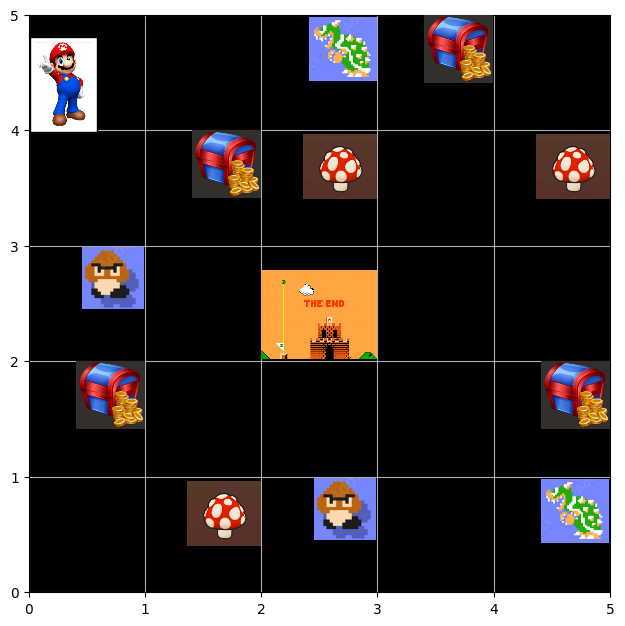

In [84]:
# Initial State Position of the Environment
env = Mario_Game_Deterministic_Environment(16) 
env.reset()
env.render()

Timestep: 1			 Performing Action: Down
Current Agent Position: [0,3] ; Current State Reward: 1 ; Total Cumulative Reward: 1
Timestep: 2			 Performing Action: Right
Current Agent Position: [1,3] ; Current State Reward: 10 ; Total Cumulative Reward: 11
Timestep: 3			 Performing Action: Down
Current Agent Position: [1,2] ; Current State Reward: 1 ; Total Cumulative Reward: 12
Timestep: 4			 Performing Action: Right
Current Agent Position: [2,2] ; Current State Reward: 50 ; Total Cumulative Reward: 62


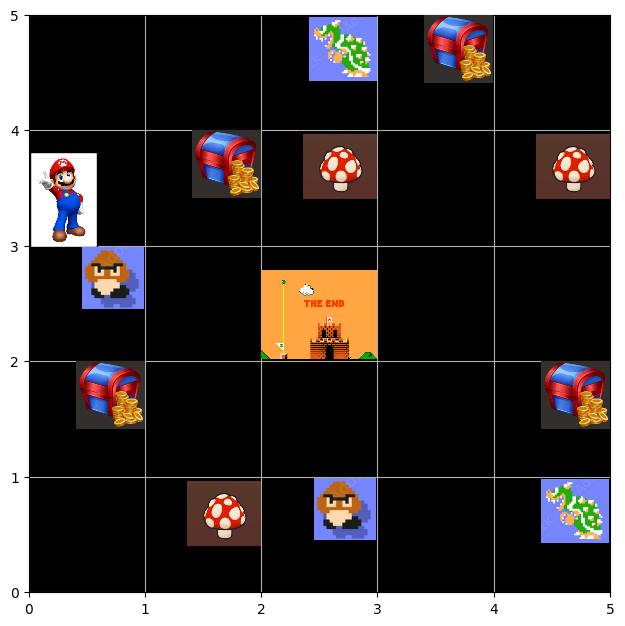

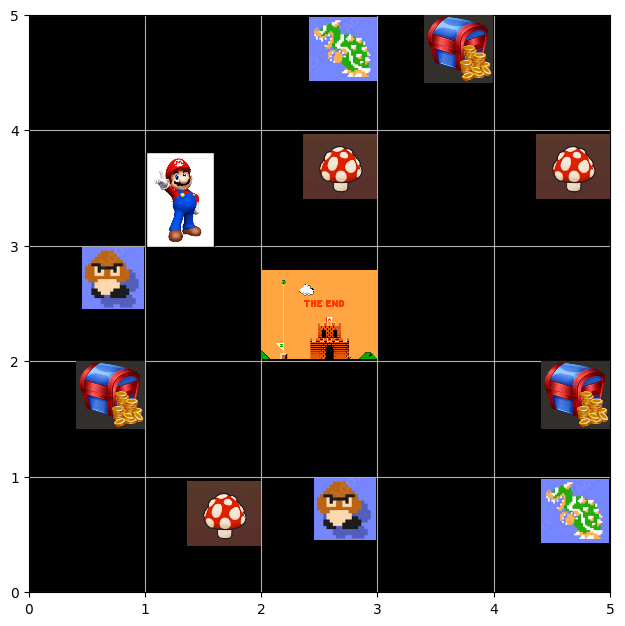

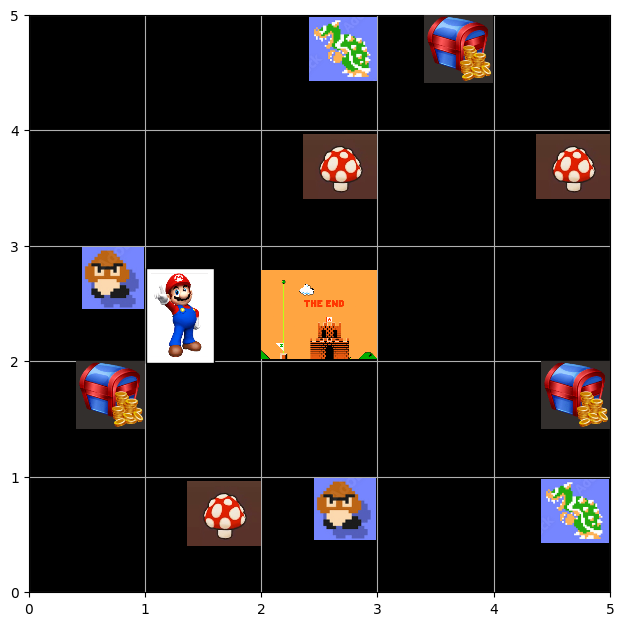

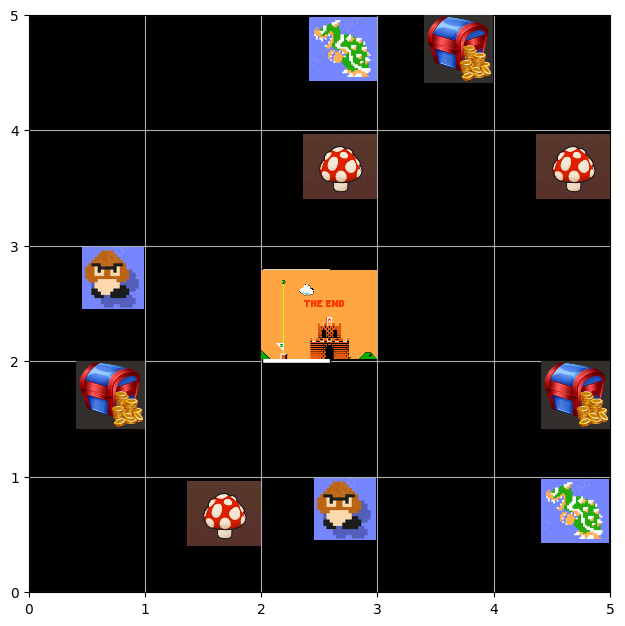

In [85]:
#Running the Mario GridWorld Game in Deterministic Environment
done = False
Actions={0:"Left",1:"Right",2:"Up",3:"Down"}
print("==================================================================================================")
while not done:
    action = random.randint(0,30)%4  #To pick a random action in range [0,3]
    pos,reward, done, info = env.step(action)
    env.render()
    print("Timestep: {}".format(env.timeStep)+"\t\t\t Performing Action: "+Actions[int(action)])
    print(info)
    print("=================================================================================================")

# **1.1 Q LEARNING - DETERMINISTIC ENVIRONMENT**

In [86]:
class Q_Learning_D():
    
    # Off-Policy TD Control
    # Approximates the optimal action-value function independent of the policy being followed.

    def __init__(self):
        
        #Intialising Q table with all zeros of size 5x5
        #Resetting Agent's position to Initial State
        self.Q_Table = np.zeros((25,4))
        self.a_pos=[0,4]
    
    def update_Q_table(self,state,action,reward):
        
        #Declaring metric dictionary keys
        updated_state = int(state_space[self.a_pos[0],self.a_pos[1]])
        if state==12:   #Goal State
            self.Q_Table[state,action] = 0
        else:    
            self.Q_Table[state,action] = round(self.Q_Table[state,action] + hyper_parameters['alpha']*(reward + hyper_parameters['gamma']*np.max(self.Q_Table[updated_state,:]) - self.Q_Table[state,action]),2)

    def train(self):
        env = Mario_Game_Deterministic_Environment(hyper_parameters['max_timesteps'])
        
        #Setting up keys for dictionary
        metrics['Timesteps']     = []
        metrics['Rewards']       = []
        metrics['Cumulative Rewards'] = [] 
        metrics['Epsilon Decay'] = []


        #Train - Perform Exploration & Exploitation to learn the optimal action for a current state
        for i in range(number_of_episodes): #number of episodes = 1000
            j = 100                         
            env.reset()
            #Updating learning rate gradually as the number of episodes increases
            if i%j == 0:
                hyper_parameters['alpha'] /= 10
                
            done = False
            while not done:
                state = int(state_space[self.a_pos[0],self.a_pos[1]])
                if random.random() < hyper_parameters['epsilon']:     #Random Policy - choose random action
                    action = random.randint(0,25)%4
                else:                                                 #Greedy Policy - choose optimal action
                    action = np.argmax(self.Q_Table[state,:])

                #Performing resultant action and updating Q-Table                  
                self.a_pos,reward, done, info = env.step(action)
                self.update_Q_table(state,action,reward)
              
            #Appending the key-values in metric dictionary         
            metrics['Timesteps'].append(env.timeStep)
            metrics['Rewards'].append(env.rewards)
            metrics['Cumulative Rewards'].append(env.cumulative_rewards)
            metrics['Epsilon Decay'].append(hyper_parameters['epsilon'])
            hyper_parameters['epsilon'] /= hyper_parameters['Epsilon Decay']
              
    def test(self,plot):
        env = Mario_Game_Deterministic_Environment(hyper_parameters['max_timesteps'])
        
        #Resetting our environment to initial state.
        env.reset()
        #Visualizing the initial state 
        env.render()
        
        metrics['Evaluation of Rewards'] = [0]
        
        done = False
        if plot:
            print("==================================================================================================")
        while not done:
            #Updating Agent's State
            state = int(state_space[env.agent_pos[0],env.agent_pos[1]])
            
            #Selecting the Optimal/Greedy Action based on our Q-Table
            action = np.argmax(self.Q_Table[state,:])                     
          
            pos,reward, done, info = env.step(action)
            
            metrics['Evaluation of Rewards'].append(env.cumulative_rewards)
            if plot:
                env.render()
                print("Timestep: {}".format(env.timeStep)+"\tState: {}".format(state)+"\t Performing Action: "+Actions[int(action)])
                print(info)
                print("=================================================================================================")

# **1.1.1 Learning Phase - Updating Q-Table**


Q-Learning Table:

[[ 1.200e-01  1.620e+00  4.000e-01  5.650e+00]
 [ 9.400e-01 -2.810e+00  4.600e-01  9.350e+00]
 [ 6.800e-01  1.960e+00  2.300e-01  6.460e+00]
 [-1.900e-01  6.700e-01 -1.900e-01  1.300e-01]
 [ 7.100e-01  1.000e-02  7.000e-02  3.060e+00]
 [ 2.060e+00  1.407e+01  1.420e+00 -1.280e+00]
 [ 2.700e+00  2.110e+01  1.760e+00  3.920e+00]
 [ 2.730e+00  1.090e+00 -9.400e-01  2.136e+01]
 [ 1.110e+00  5.100e+00  1.550e+00  3.400e-01]
 [ 7.500e-01 -1.000e-02  4.400e-01  2.700e-01]
 [ 1.500e-01  1.460e+00  6.800e-01  3.590e+00]
 [ 7.000e-02  1.972e+01  5.400e-01  2.500e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 1.980e+00  8.000e-02  1.200e-01  4.000e-02]
 [ 1.400e-01 -8.000e-02  6.000e-02  4.600e-01]
 [-1.100e-01  9.500e-01  3.000e-01  3.000e-01]
 [ 9.000e-02  2.200e-01  8.700e-01  4.430e+00]
 [ 9.000e-02  2.000e-02  6.950e+00 -2.000e-02]
 [ 3.200e-01  2.000e-01  2.000e-02  0.000e+00]
 [ 6.000e-02  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  2.940e+00  6.400e-01  1.20

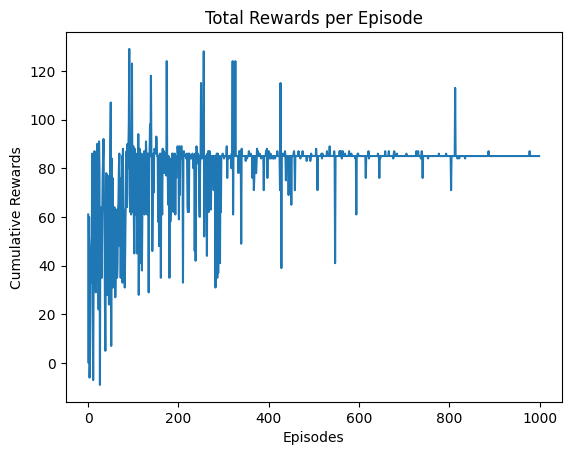

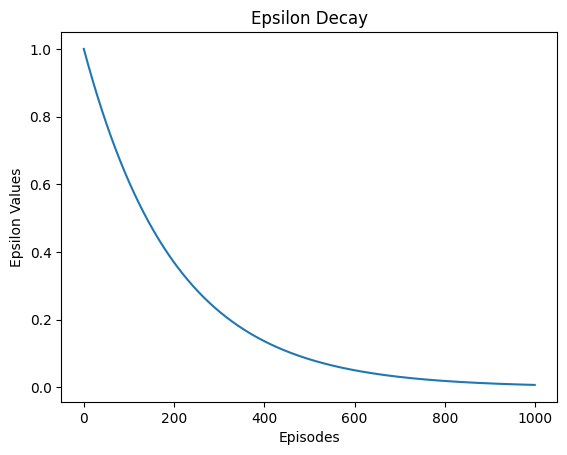

In [87]:
#Giving specific values for all the hyper parameters
hyper_parameters = {}
hyper_parameters['alpha'] = 0.2           # Learning-rate
hyper_parameters['max_timesteps'] = 100   #no. of timesteps per episode
hyper_parameters['epsilon'] = 1
hyper_parameters['Epsilon Decay'] = 1.005  #Exploration Rate  
hyper_parameters['gamma'] = 0.8          #discount-factor
number_of_episodes = 1000                 # No of episodes
metrics = {}
ql = Q_Learning_D()
ql.train()
print("\nQ-Learning Table:\n")
print(ql.Q_Table)
with open("Deterministic_Q_Learning.pkl",'wb') as f:
    pickle.dump(ql.Q_Table,f)
#Plotting all the required graphs
plt.plot(metrics['Cumulative Rewards'])
plt.title("Total Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Rewards")
plt.show()
plt.plot(metrics['Epsilon Decay'])
plt.title("Epsilon Decay")
plt.xlabel("Episodes")
plt.ylabel("Epsilon Values")
plt.show()

# **1.1.2 Testing Phase - Agent Selects Optimal Action using Q-Table**
# **and reaches GOAL POSITION**

Timestep: 1	State: 0	 Performing Action: Down
Current Agent Position: [0,3] ; Current State Reward: 1 ; Total Cumulative Reward: 1
Timestep: 2	State: 5	 Performing Action: Right
Current Agent Position: [1,3] ; Current State Reward: 10 ; Total Cumulative Reward: 11
Timestep: 3	State: 6	 Performing Action: Right
Current Agent Position: [2,3] ; Current State Reward: 25 ; Total Cumulative Reward: 36
Timestep: 4	State: 7	 Performing Action: Down
Current Agent Position: [2,2] ; Current State Reward: 50 ; Total Cumulative Reward: 86


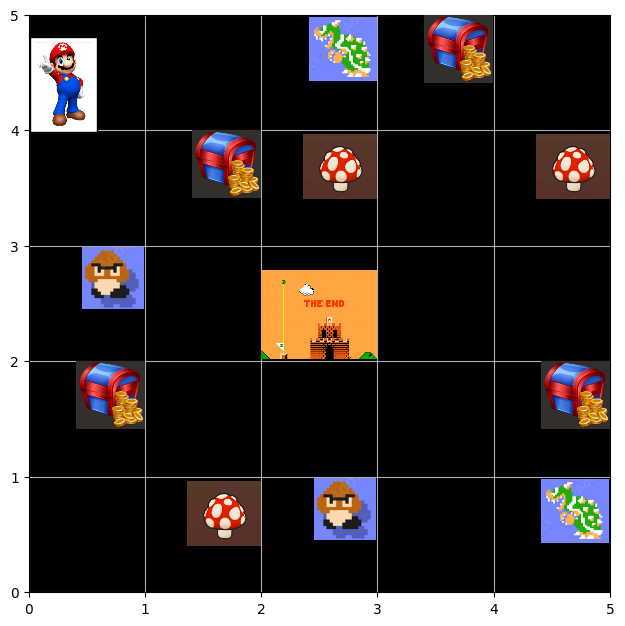

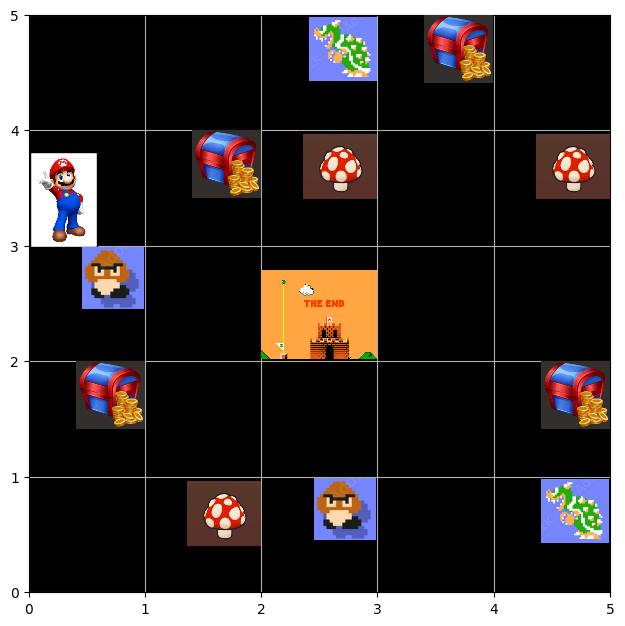

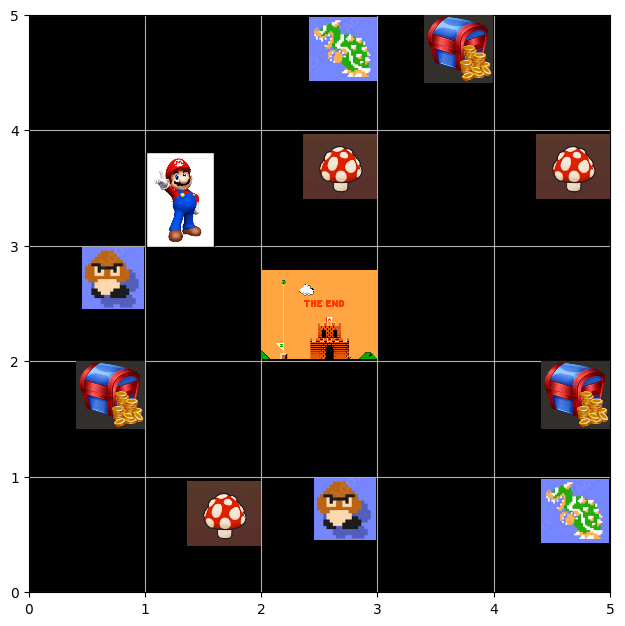

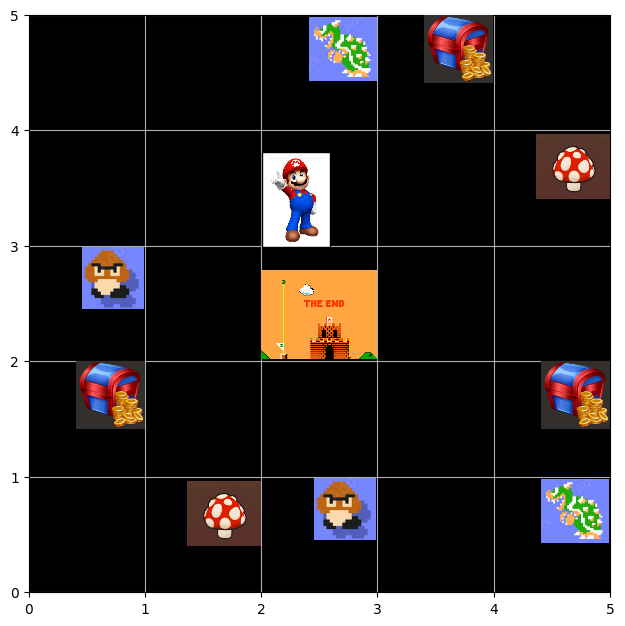

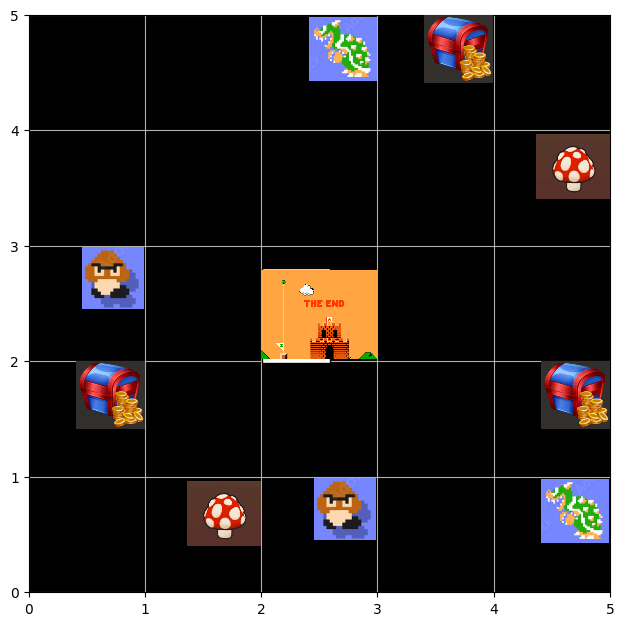

In [88]:
# Agent performing greedy actions to reach goal position State:12 Position:[2,2]
ql.test(plot=True)

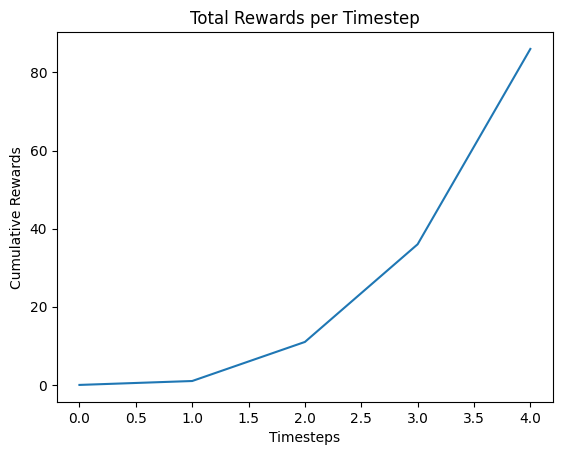

In [89]:
#Plotting Cummulative rewards as time-steps increases
metrics_ql = copy.deepcopy(metrics)
plt.plot(metrics_ql['Evaluation of Rewards'])
plt.title("Total Rewards per Timestep")
plt.xlabel("Timesteps")
plt.ylabel("Cumulative Rewards")
plt.show()

# **1.2 SARSA - DETERMINISTIC ENVIRONMENT**

In [90]:
class SARSA_D():
    
    # On-Policy TD Control
    # Approximates the optimal action-value function based on the next state and action.

    def __init__(self):
        
        #Intialising Q table with all zeros of size 5x5
        #Resetting Agent's position to Initial State
        self.Q_Table = np.zeros((25,4))
        self.a_pos=[0,4]
    
    def update_Q_table(self, state, action, reward, updated_state, next_action):
        
        #Updating Q-Table using SARSA
        updated_state = int(state_space[self.a_pos[0],self.a_pos[1]])
        if state==12:   #Goal State
            self.Q_Table[state,action] = 0
        else: 
            self.Q_Table[state,action] = round(self.Q_Table[state,action] + hyper_parameters['alpha']*(reward + hyper_parameters['gamma']*self.Q_Table[updated_state,next_action] - self.Q_Table[state,action]),2)
        
    def train(self):

        env = Mario_Game_Deterministic_Environment(hyper_parameters['max_timesteps'])
        
        #Declaring metric dictionary keys
        metrics['Timesteps']     = []
        metrics['Rewards']       = []
        metrics['Cumulative Rewards'] = [] 
        metrics['Epsilon Decay'] = []

        #Train - Perform Exploration & Exploitation to learn the optimal action for a current state
        for i in range(number_of_episodes):
            j = 100
            env.reset()
            #Updating learning rate gradually as the number of episodes increases
            if i%j == 0:
                hyper_parameters['alpha'] /= 10
                
            done = False
            while not done:
                state=int(state_space[self.a_pos[0],self.a_pos[1]])
                if random.random() < hyper_parameters['epsilon']:                 #Random Policy - choose random action
                  action = random.randint(0,30)%4         
                else:                                                             #Greedy Policy - choose optimal action
                  action = np.argmax(self.Q_Table[state,:])                             
                self.a_pos,reward, done, info = env.step(action)
                updated_state = int(state_space[self.a_pos[0],self.a_pos[1]])
                if random.random() < hyper_parameters['epsilon']:                 #Random Policy - choose random action
                    next_action = random.randint(0,30)%4
                else:                                                             #Greedy Policy - choose optimal action
                    next_action = np.argmax(self.Q_Table[updated_state,:])
                self.update_Q_table(state, action, reward, updated_state, next_action)
                
            #Appending the key-values in metric dictionary        
            metrics['Timesteps'].append(env.timeStep)
            metrics['Rewards'].append(env.rewards)
            metrics['Cumulative Rewards'].append(env.cumulative_rewards)
            metrics['Epsilon Decay'].append(hyper_parameters['epsilon'])
            hyper_parameters['epsilon'] /= hyper_parameters['Epsilon Decay']
                
    def test(self):
        
        env = Mario_Game_Deterministic_Environment(hyper_parameters['max_timesteps'])
        #Resetting our environment to initial state.
        env.reset()
        #Visualizing the initial state 
        env.render()
        
        metrics['Evaluation of Rewards'] = [0]
        
        done = False
        print("==================================================================================================")
        while not done:
            #Updating Agent's State
            state = int(state_space[env.agent_pos[0],env.agent_pos[1]])
            
            #Selecting the Optimal/Greedy Action based on our Q-Table
            action = np.argmax(self.Q_Table[state,:])                     
          
            pos,reward, done, info = env.step(action)
            env.render()
            metrics['Evaluation of Rewards'].append(env.cumulative_rewards)
            
            print("Timestep: {}".format(env.timeStep)+"\tState: {}".format(state)+"\t Performing Action: "+Actions[int(action)])
            print(info)
            print("=================================================================================================")

# **1.2.1 Learning Phase - Updating Q-Table**

[[-6.100e-01  2.340e+00 -3.800e-01  1.270e+00]
 [ 6.100e-01 -3.710e+00 -1.400e-01  9.500e+00]
 [ 3.900e-01  2.520e+00 -1.500e-01  7.670e+00]
 [ 1.000e-02  5.300e-01 -2.200e-01  2.300e-01]
 [ 3.500e-01 -5.000e-02 -7.000e-02  3.390e+00]
 [ 2.000e-02  6.980e+00  5.200e-01 -1.350e+00]
 [ 9.100e-01  2.017e+01  9.500e-01  1.490e+00]
 [ 2.070e+00  1.070e+00 -1.320e+00  2.530e+01]
 [ 1.390e+00  5.080e+00  1.410e+00  1.900e-01]
 [ 6.700e-01 -1.300e-01  1.800e-01  2.200e-01]
 [-1.200e-01  7.600e-01  4.000e-01  2.430e+00]
 [-5.000e-01  1.366e+01  6.800e-01  3.200e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 1.540e+00  1.000e-01  3.400e-01  8.000e-02]
 [ 4.000e-02 -4.000e-02  2.000e-02  1.580e+00]
 [-8.000e-02  4.600e-01  2.200e-01  7.000e-02]
 [ 5.000e-01  1.100e-01  1.000e-01  3.650e+00]
 [ 2.000e-02  8.000e-02  0.000e+00  0.000e+00]
 [ 2.000e-02  2.000e-02  1.400e-01  4.000e-02]
 [ 6.000e-02 -2.000e-02  2.000e-02 -1.600e-01]
 [-7.000e-02  6.700e-01  2.000e-02  5.000e-02]
 [ 2.300e-01 

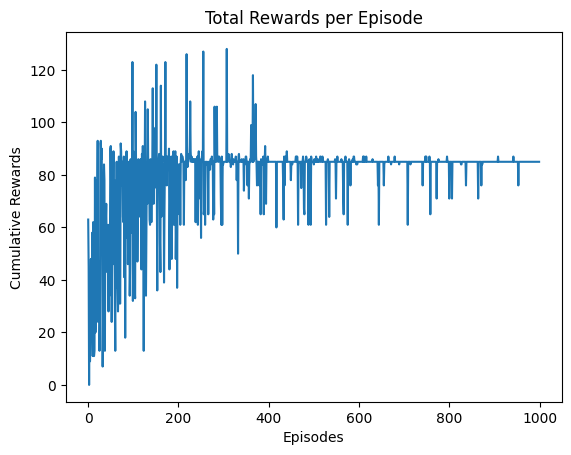

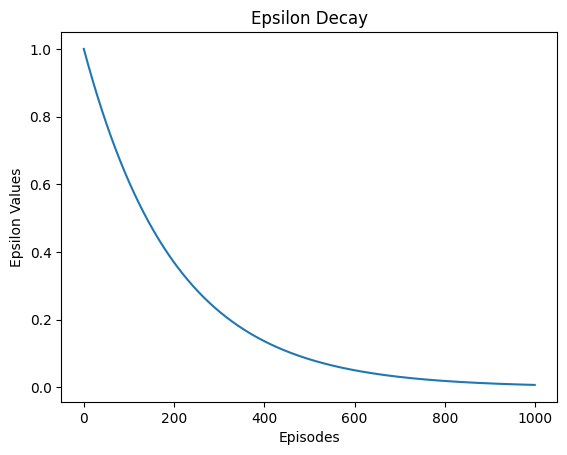

In [91]:
#Giving specific values for all the hyper parameters
hyper_parameters = {}
hyper_parameters['alpha'] = 0.2
hyper_parameters['max_timesteps'] = 100
hyper_parameters['epsilon'] = 1
hyper_parameters['Epsilon Decay'] = 1.005
hyper_parameters['gamma'] = 0.8
number_of_episodes = 1000
metrics = {}
metrics['Epsilon Decay'] = []
sa = SARSA_D()
sa.train()
print(sa.Q_Table)
with open("Deterministic_SARSA.pkl",'wb') as f:
    pickle.dump(sa.Q_Table,f)
#Plotting all the required graphs
plt.plot(metrics['Cumulative Rewards'])
plt.title("Total Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Rewards")
plt.show()
plt.plot(metrics['Epsilon Decay'])
plt.title("Epsilon Decay")
plt.xlabel("Episodes")
plt.ylabel("Epsilon Values")
plt.show()


# **1.2.2 Testing Phase - Agent Selects Optimal Action using Q-Table**
# **and reaches GOAL POSITION**

Timestep: 1	State: 0	 Performing Action: Right
Current Agent Position: [1,4] ; Current State Reward: 1 ; Total Cumulative Reward: 1
Timestep: 2	State: 1	 Performing Action: Down
Current Agent Position: [1,3] ; Current State Reward: 10 ; Total Cumulative Reward: 11
Timestep: 3	State: 6	 Performing Action: Right
Current Agent Position: [2,3] ; Current State Reward: 25 ; Total Cumulative Reward: 36
Timestep: 4	State: 7	 Performing Action: Down
Current Agent Position: [2,2] ; Current State Reward: 50 ; Total Cumulative Reward: 86


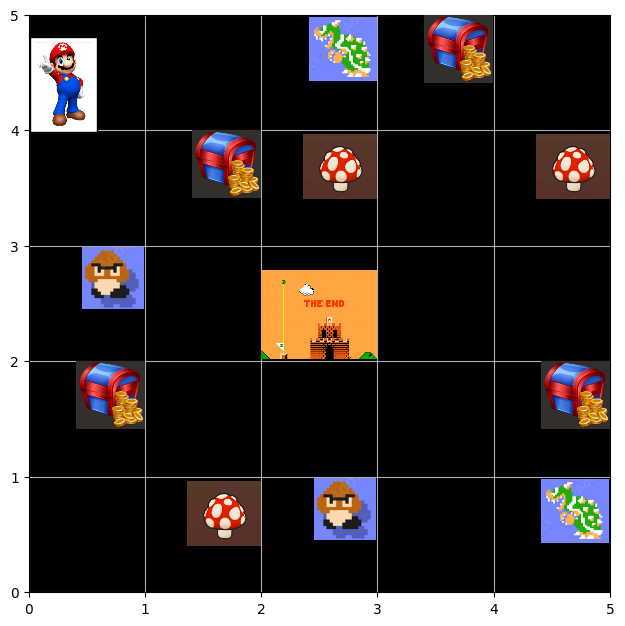

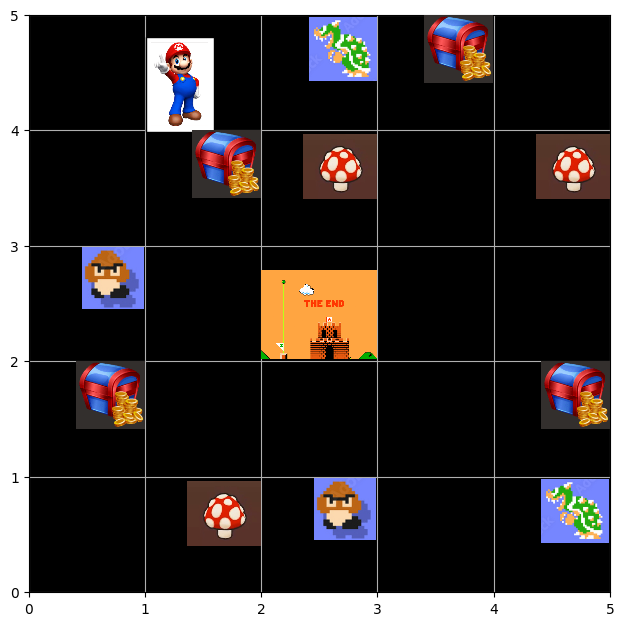

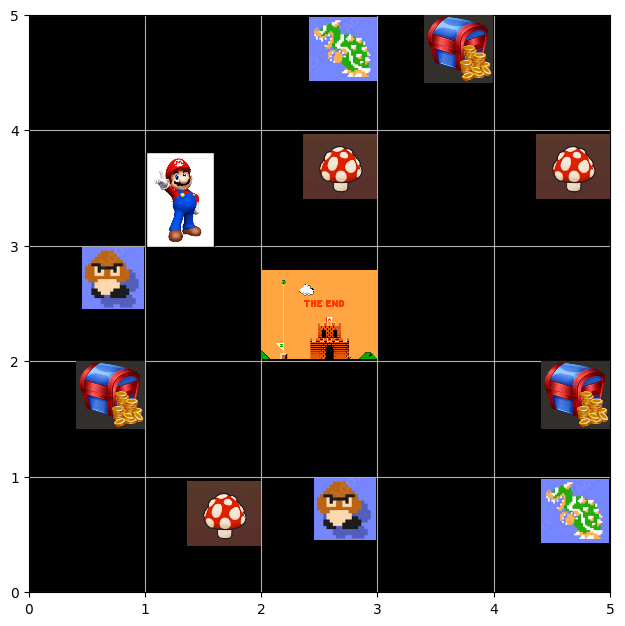

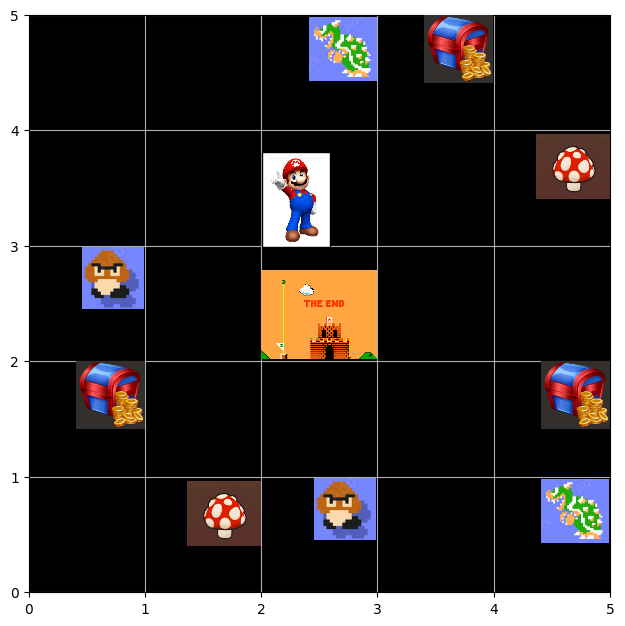

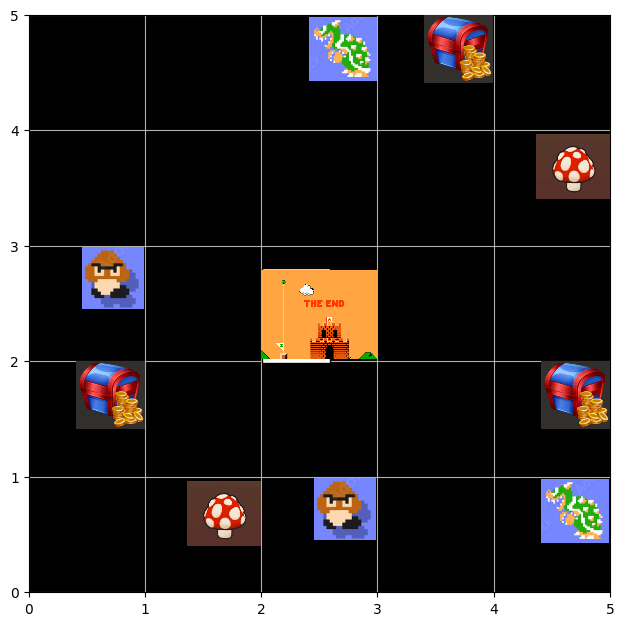

In [92]:
# Agent performing greedy actions to reach goal position State:12 Position:[2,2]
sa.test()

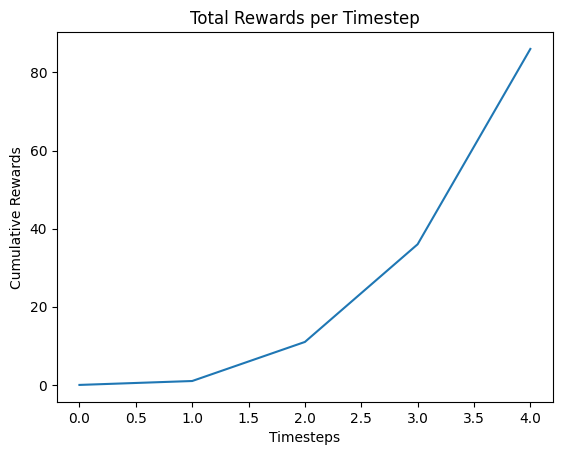

In [93]:
#Plotting Cummulative rewards as time-steps increases
metrics_sa = copy.deepcopy(metrics)
plt.plot(metrics_sa['Evaluation of Rewards'])
plt.title("Total Rewards per Timestep")
plt.xlabel("Timesteps")
plt.ylabel("Cumulative Rewards")
plt.show()

# **1.3 Comparing Q-Learning And SARSA - DETERMINISTIC ENVIRONMENT**

Text(0.5, 0.01, 'Q-Learning : Blue, SARSA : Orange')

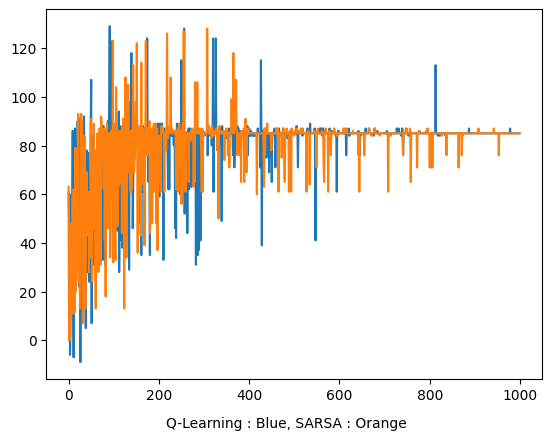

In [94]:
#Comparing the Q-learing and SARSA Cummulative Rewards
plt.plot(metrics_ql['Cumulative Rewards'],markersize=5)
plt.plot(metrics_sa['Cumulative Rewards'],markersize=5)
plt.figtext(0.5, 0.01, "Q-Learning : Blue, SARSA : Orange", horizontalalignment='center')

# **1.4 Hyperparameter Tuning - DETERMINISTIC ENVIRONMENT**

# **1.4.1 Tuning Discount Factor - 0.7 ,0.8, 0.9**


Gamma:0.7
Q-Learning Table:

[[ 1.100e-01  5.020e+00  6.000e-02  2.540e+00]
 [ 1.090e+00 -2.110e+00  1.280e+00  1.369e+01]
 [ 7.200e-01  1.710e+00  8.800e-01  1.400e+01]
 [ 6.300e-01  1.100e-01 -1.600e-01  1.200e-01]
 [ 6.800e-01  0.000e+00 -9.000e-02  0.000e+00]
 [ 4.400e-01  1.119e+01  5.800e-01 -1.260e+00]
 [ 2.200e+00  2.538e+01  2.020e+00  2.950e+00]
 [ 5.110e+00  6.100e-01 -1.000e-02  3.202e+01]
 [ 3.050e+00  2.040e+00  4.600e-01  1.800e-01]
 [ 1.300e-01  0.000e+00  7.000e-02  5.000e-02]
 [-7.000e-02  1.700e+00  7.000e-01  2.640e+00]
 [-2.100e-01  1.519e+01  6.500e-01  2.700e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  7.000e-02  3.000e-02  4.000e-02]
 [ 0.000e+00  0.000e+00  5.800e-01  4.000e-01]
 [-8.000e-02  2.500e-01  5.600e-01  1.900e-01]
 [ 2.200e-01  1.100e-01  7.000e-02  3.920e+00]
 [ 9.000e-02  4.000e-02  0.000e+00  0.000e+00]
 [ 5.000e-02  4.300e-01  4.000e-02  2.000e-02]
 [ 1.100e-01 -0.000e+00 -2.000e-02  0.000e+00]
 [-4.000e-02  1.390e+00  5.000

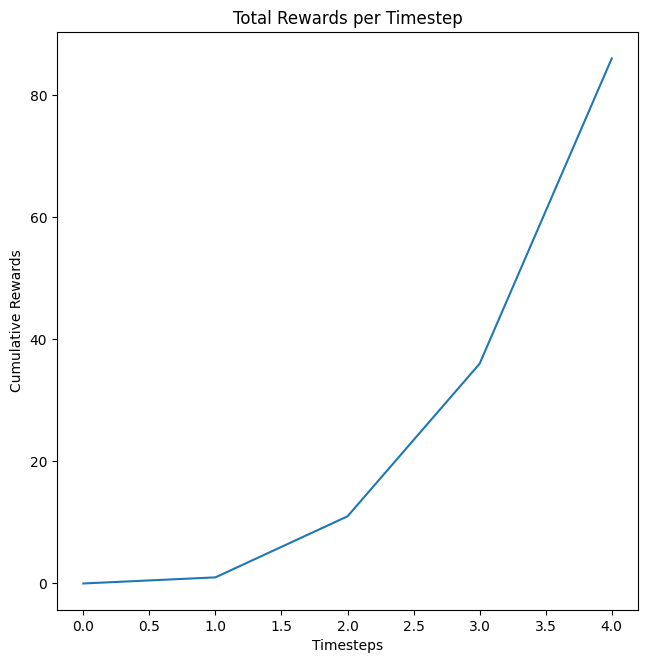


Gamma:0.8
Q-Learning Table:

[[ 3.800e-01  5.810e+00  1.900e-01  1.470e+00]
 [ 1.250e+00 -2.170e+00  8.000e-01  1.461e+01]
 [ 1.430e+00  2.560e+00  6.300e-01  1.496e+01]
 [ 7.600e-01  3.100e-01 -7.000e-02  1.820e+00]
 [ 2.120e+00  2.500e-01 -1.100e-01  6.400e-01]
 [ 7.300e-01  8.970e+00  7.000e-01 -1.120e+00]
 [ 2.120e+00  2.204e+01  3.200e+00  2.400e+00]
 [ 3.210e+00  2.040e+00  9.000e-02  2.700e+01]
 [ 1.130e+00  8.770e+00  1.080e+00  1.300e-01]
 [ 5.800e-01 -3.000e-02  6.700e-01  1.600e-01]
 [ 1.000e-01  3.800e-01  4.600e-01  2.980e+00]
 [-2.100e-01  1.127e+01  1.530e+00  4.900e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 3.220e+00  3.000e-02  2.000e-02  2.000e-02]
 [ 1.400e-01  1.200e-01  1.000e-01  8.300e-01]
 [-8.000e-02  9.300e-01  4.500e-01  6.000e-02]
 [ 4.500e-01  3.500e-01  5.500e-01  3.870e+00]
 [ 1.000e-02  2.000e-02  4.070e+00 -1.900e-01]
 [ 8.000e-02  0.000e+00  2.000e-02  0.000e+00]
 [ 2.000e-02  2.000e-02  9.000e-02  0.000e+00]
 [-1.000e-02  6.300e-01  6.000

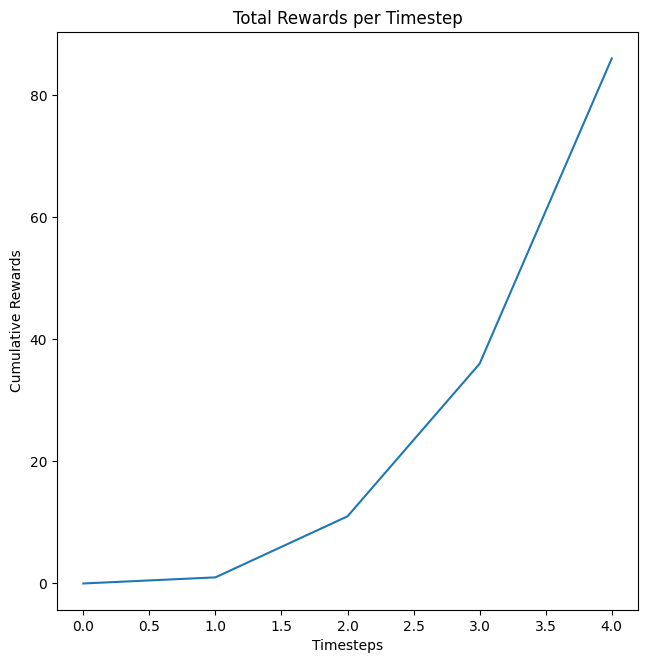


Gamma:0.9
Q-Learning Table:

[[ 8.700e-01  9.550e+00  8.400e-01  2.700e+00]
 [ 2.220e+00 -1.450e+00  2.780e+00  1.833e+01]
 [ 1.760e+00  2.220e+00  9.900e-01  1.247e+01]
 [ 2.300e-01  2.100e-01 -6.000e-02  1.090e+00]
 [ 8.800e-01 -9.000e-02 -1.000e-01  7.000e-01]
 [ 9.600e-01  1.075e+01  1.250e+00 -9.100e-01]
 [ 2.700e+00  2.651e+01  3.380e+00  2.460e+00]
 [ 5.170e+00  1.800e+00  3.900e-01  2.673e+01]
 [ 2.190e+00  6.680e+00  9.000e-01  7.300e-01]
 [ 1.500e+00 -9.000e-02  2.200e-01  7.000e-02]
 [-1.000e-02  4.100e-01  7.800e-01  2.120e+00]
 [-3.200e-01  1.303e+01  6.900e-01  1.800e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 3.970e+00  6.000e-02  2.600e-01  5.000e-02]
 [ 8.000e-02 -5.000e-02  4.800e-01  2.200e-01]
 [-4.000e-02  4.800e-01  1.700e-01  1.500e-01]
 [ 3.300e-01  5.100e-01  4.800e-01  2.150e+00]
 [ 3.000e-02  2.000e-02  6.910e+00 -1.100e-01]
 [ 2.000e-02  4.500e-01  2.000e-02  4.000e-02]
 [ 7.000e-02 -6.000e-02  0.000e+00 -2.000e-01]
 [-1.000e-02  1.450e+00  2.700

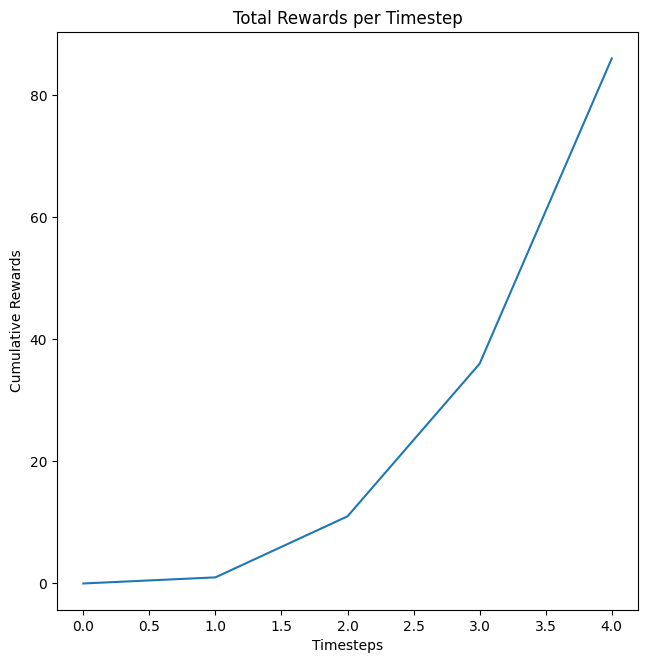

In [95]:
#Giving specific values for all the hyper parameters
for gamma in [0.7,0.8,0.9]:
    hyper_parameters = {}
    hyper_parameters['alpha'] = 0.2           # Learning-rate
    hyper_parameters['max_timesteps'] = 100   #no. of timesteps per episode
    hyper_parameters['epsilon'] = 1
    hyper_parameters['Epsilon Decay'] = 1.005  #Exploration Rate  
    hyper_parameters['gamma'] = gamma          #discount-factor
    number_of_episodes = 1000                 # No of episodes
    metrics = {}
    ql = Q_Learning_D()
    ql.train()
    print("\nGamma:"+str(gamma))
    print("Q-Learning Table:\n")
    print(ql.Q_Table)
    #Plotting all the required graphs
    ql.test(plot=False)
    plt.clf()
    plt.plot(metrics['Evaluation of Rewards'])
    plt.title("Total Rewards per Timestep")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Rewards")
    plt.show()

# **1.4.2 Learning rate - 0.1 ,0.15, 0.2**


Q-Learning Table:

[[-2.000e-01  2.010e+00 -1.900e-01  5.400e-01]
 [ 4.800e-01 -1.690e+00  1.700e-01  6.910e+00]
 [ 3.300e-01  1.280e+00  1.200e-01  4.880e+00]
 [ 3.000e-02  2.500e-01 -7.000e-02  5.000e-02]
 [ 9.000e-02  2.000e-02 -1.000e-02  2.100e+00]
 [-1.000e-02  4.410e+00  2.900e-01 -8.500e-01]
 [ 6.500e-01  1.361e+01  7.800e-01  1.110e+00]
 [ 1.330e+00  3.100e-01 -1.000e+00  1.656e+01]
 [ 3.600e-01  2.420e+00  5.900e-01  8.000e-02]
 [ 2.300e-01 -4.000e-02  8.000e-02  9.000e-02]
 [-6.000e-02  5.000e-01  2.100e-01  7.800e-01]
 [-2.400e-01  9.560e+00  3.000e-01  9.000e-02]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 2.130e+00  3.000e-02  2.000e-02  1.000e-02]
 [ 3.000e-02 -1.000e-02  2.900e-01  2.600e-01]
 [-2.000e-02  1.300e-01  3.000e-02  4.000e-02]
 [ 1.900e-01  3.000e-02  1.500e-01  1.330e+00]
 [ 4.000e-02  3.000e-02  1.150e+00 -5.000e-02]
 [-1.000e-02  0.000e+00  1.000e-02  1.000e-02]
 [ 1.000e-02 -1.000e-02  0.000e+00 -1.000e-02]
 [-4.000e-02  5.700e-01  2.000e-02 -1.00

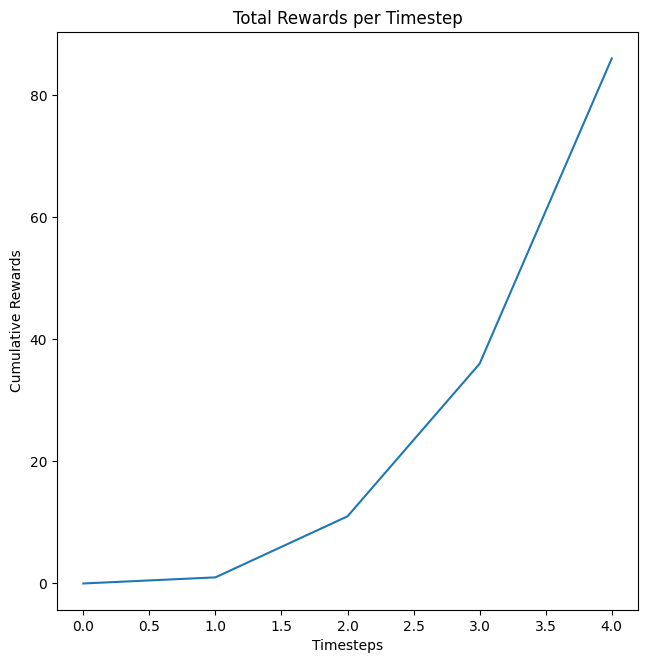


Q-Learning Table:

[[-2.000e-02  3.970e+00 -8.000e-02  1.240e+00]
 [ 7.300e-01 -2.550e+00  6.300e-01  9.870e+00]
 [ 9.300e-01  1.910e+00  4.700e-01  9.600e+00]
 [ 1.300e-01  3.300e-01 -1.000e-01  8.000e-02]
 [ 1.600e-01 -5.000e-02 -4.000e-02  2.330e+00]
 [ 2.600e-01  6.730e+00  5.700e-01 -9.200e-01]
 [ 1.510e+00  1.773e+01  1.340e+00  2.090e+00]
 [ 4.230e+00  4.300e-01 -1.300e-01  2.261e+01]
 [ 2.180e+00  2.720e+00  3.200e-01  1.500e-01]
 [ 1.500e-01  7.000e-02  1.700e-01  2.100e-01]
 [-2.000e-02  7.300e-01  3.200e-01  1.930e+00]
 [-2.500e-01  1.286e+01  9.400e-01  2.000e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 5.120e+00  5.000e-02  2.000e-02  2.000e-02]
 [ 3.000e-01 -2.000e-02  4.000e-02  0.000e+00]
 [-7.000e-02  3.800e-01  7.000e-02  5.000e-02]
 [ 5.200e-01  5.000e-02  1.000e+00  3.800e-01]
 [ 0.000e+00  7.000e-02  0.000e+00 -8.000e-02]
 [ 5.000e-02  3.000e-02  3.000e-02  4.000e-02]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [-2.000e-02  8.500e-01  4.000e-02 -2.00

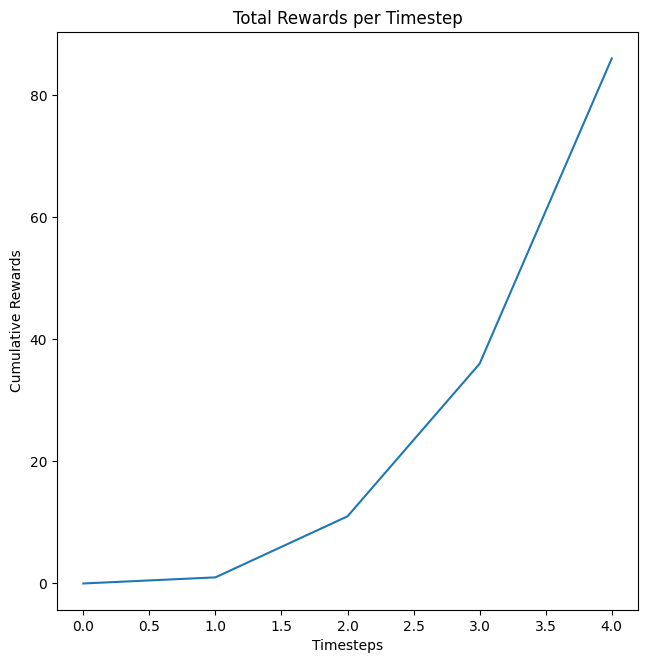


Q-Learning Table:

[[ 6.900e-01  6.660e+00  5.200e-01  1.890e+00]
 [ 1.730e+00 -1.550e+00  1.550e+00  1.516e+01]
 [ 1.530e+00  2.870e+00  9.500e-01  1.530e+01]
 [ 1.360e+00  2.600e-01 -8.000e-02  3.100e-01]
 [ 3.700e-01 -5.000e-02 -9.000e-02  1.170e+00]
 [ 1.800e-01  9.190e+00  8.400e-01 -1.080e+00]
 [ 1.430e+00  2.519e+01  2.170e+00  2.860e+00]
 [ 3.020e+00  1.040e+00  2.100e-01  3.033e+01]
 [ 1.500e+00  4.110e+00  1.320e+00  3.300e-01]
 [ 5.300e-01 -1.100e-01  6.000e-02  2.800e-01]
 [-5.000e-02  7.200e-01  3.800e-01  2.110e+00]
 [-4.200e-01  1.332e+01  7.100e-01  2.400e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 5.090e+00  5.000e-02  1.200e-01  4.000e-02]
 [ 2.900e-01 -3.000e-02  2.000e-02  7.900e-01]
 [-1.800e-01  1.200e-01  0.000e+00  6.700e-01]
 [ 6.400e-01  2.100e-01  1.200e-01  2.140e+00]
 [ 7.000e-02  0.000e+00  1.000e+00 -1.100e-01]
 [ 6.000e-02  2.000e-02  1.100e-01  2.000e-02]
 [ 8.000e-02 -2.000e-02  3.000e-02  6.000e-02]
 [ 5.000e-02  3.470e+00  1.200e-01  9.00

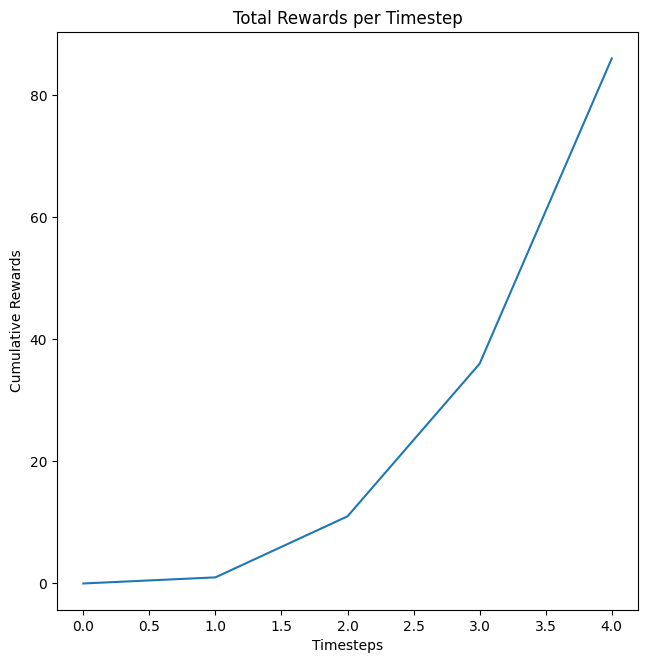

In [96]:
#Giving specific values for all the hyper parameters
for alpha in [0.1,0.15,0.2]:
    hyper_parameters = {}
    hyper_parameters['alpha'] = alpha           # Learning-rate
    hyper_parameters['max_timesteps'] = 100   #no. of timesteps per episode
    hyper_parameters['epsilon'] = 1
    hyper_parameters['Epsilon Decay'] = 1.005  #Exploration Rate  
    hyper_parameters['gamma'] = 0.8          #discount-factor
    number_of_episodes = 1000                 # No of episodes
    metrics = {}
    ql = Q_Learning_D()
    ql.train()
    print("\nQ-Learning Table:\n")
    print(ql.Q_Table)
    #Plotting all the required graphs
    ql.test(plot=False)
    plt.clf()
    plt.plot(metrics['Evaluation of Rewards'])
    plt.title("Total Rewards per Timestep")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Rewards")
    plt.show()

## **2. STOCHASTIC ENVIRONMENT**

In [97]:
class Mario_Game_Stochastic_Environment(gym.Env):
    def __init__(self, max_timeSteps):
        #GridWorld Game - Observation space Definition( no. of rows * columns)
        self.observation_space = spaces.Discrete(25)
        #GridWorld Game - Setting the maximum no. of steps agent can take
        self.max_timeSteps = 16
            
    def reset(self):

        #GridWorld Game - Agent's Initial Position
        self.agent_pos = np.array([0, 4])
        #GridWorld Game - Agent's EndGoal Position
        self.end_goal_pos = np.array([2,2])

        #GridWorld Game - Positions of Gold_Chest (+ Reward)
        self.gold_chest_pos= np.array([[0,1],[1,3],[3,4],[4,1]])
        #GridWorld Game - Positions of Food (+ Reward)
        self.Food_pos = np.array([[2,3],[1,0],[4,3]])
        #GridWorld Game - Positions of devils (- Reward)
        self.devil_pos = np.array([[2,0],[0,2]])
        #GridWorld Game - Positions of dragons (- Reward)
        self.dragon_pos = np.array([[2,4],[4,0]])

        #GridWorld Game - Setting initial values for rewards, cumulative_rewards,timesteps
        self.rewards = 0      
        self.cumulative_rewards = 0
        self.timeStep = 0
        self.state = np.zeros(grid_world_size)
        self.done = False
        return
    
    def step(self, action):
        #Setting Initial state to a random state from the set of actions 
        self.state = np.random.choice(self.observation_space.n)
        previous_pos = self.agent_pos.copy()
        a = np.random.random()
        #Implementing randomness for the movement or action of agent in Stochastic Environment
        if action == 0:
          if (a<0.76):
            self.agent_pos[0] += 1
          else:
            self.agent_pos[0] +=2
        if action == 1:
          if (a<=0.54):
            self.agent_pos[0] -= 1
          else:
            self.agent_pos = [0,0]
        if action == 2:
          if (a<0.91):
            self.agent_pos[1] += 1
          else:
            self.agent_pos[1] += 2
        if action == 3:
          if (a>0.3):
            self.agent_pos[1] -= 1
          else:
            self.agent_pos = [2,0]

        #To ensure the Agent is within the 5x5 grid limits - clip function
        self.agent_pos = np.clip(self.agent_pos, 0, 4)
        self.state = np.zeros(grid_world_size)
        
        #GridWorld Game Rewards Configuration and Unconfiguration once they are collected
        reward = 1
        #Reward for Previous Position
        if np.all(self.agent_pos == previous_pos):
            reward = -1
        #Reward for End Goal Position
        if (self.agent_pos == self.end_goal_pos).all():
            reward = 50
            self.done = True
            self.rewards += 1
        #Positive Reward for Gold Chest Position
        if (np.any(np.all(self.agent_pos == self.gold_chest_pos, axis=1))):
            reward = 10
            for index in range(len(self.gold_chest_pos)):
                if (self.gold_chest_pos[index]==self.agent_pos).all():
                    self.gold_chest_pos = np.delete(self.gold_chest_pos, index, axis=0)
                    self.rewards += 1
                    break
        #Positive Reward for Food Position
        if (np.any(np.all(self.agent_pos == self.Food_pos, axis=1))):
            reward = 25
            for index in range(len(self.Food_pos)):
                if (self.Food_pos[index]==self.agent_pos).all():
                    self.Food_pos = np.delete(self.Food_pos, index, axis=0)
                    self.rewards += 1
                    break
        #Negative Reward for Devil Position
        if (np.any(np.all(self.agent_pos == self.devil_pos, axis=1))):
            reward = -5
            for index in range(len(self.devil_pos)):
                if (self.devil_pos[index]==self.agent_pos).all():
                    self.devil_pos = np.delete(self.devil_pos, index, axis=0)
                    break
        #Negative Reward for Dragon Position
        if (np.any(np.all(self.agent_pos == self.dragon_pos, axis=1))):
            reward = -10
            for index in range(len(self.dragon_pos)):
                if (self.dragon_pos[index]==self.agent_pos).all():
                    self.dragon_pos = np.delete(self.dragon_pos, index, axis=0)
                    break 

        #Calculating the cummulative rewards until the current timestep
        self.cumulative_rewards += reward
        self.timeStep += 1

        #Checking if we reached Goal Position or reached the maximum timesteps allowed
        if not self.done:
            self.done = True if self.timeStep >= self.max_timeSteps else False

        #Storing the Agent's  Current Position and Reward , Cummulative Rewards
        info = "Current Agent Position: [" + str(self.agent_pos[0]) + "," + str(self.agent_pos[1]) + "] ; " + "Current Reward: " + str(reward) + " ; " + "Total Cumulative Reward: " + str(self.cumulative_rewards)
        return self.agent_pos,reward, self.done, info
    
    def render(self):
        #Plot size
        fig,ax = plt.subplots(figsize=(7.5,7.5),facecolor="white")
        ax.set_xlim(0,5)
        ax.set_ylim(0,5)
        plt.grid()
        ax.set_facecolor("black")
        agent1_pos,goal1_pos = False,False
        plt.xticks([0,1,2,3,4,5])
        plt.yticks([0,1,2,3,4,5])

        if not agent1_pos:
            #For Agent's Visualization
            agent = AnnotationBbox(OffsetImage(plt.imread('agent.png'), zoom=0.2), list(map(add, self.agent_pos , [0.3, 0.4])), frameon=True)
            ax.add_artist(agent)
        if not goal1_pos:
            #For End Goal Visulaization
            goal = AnnotationBbox(OffsetImage(plt.imread('goal_pos.png'), zoom=0.087), list(map(add, self.end_goal_pos , [0.5, 0.4])), frameon=False)
            ax.add_artist(goal)

        for Food1_pos in self.Food_pos:
            #For Mushrooom Food State Visualization
            Food = AnnotationBbox(OffsetImage(plt.imread('Food.png'), zoom=0.098), list(map(add, Food1_pos, [0.68, 0.68])), frameon=False)
            ax.add_artist(Food)
        for gold1_chest_pos in self.gold_chest_pos:
            #For Gold Chest State Visulaization
            gold = AnnotationBbox(OffsetImage(plt.imread('gold_chest.png'), zoom=0.175), list(map(add, gold1_chest_pos, [0.7, 0.7])), frameon=False)
            ax.add_artist(gold)

        for devil1_pos in self.devil_pos:
            #For Devil state Visualization
            devil = AnnotationBbox(OffsetImage(plt.imread('Devil.png'), zoom=0.25), list(map(add, devil1_pos, [0.72, 0.72])), frameon=False)
            ax.add_artist(devil)
        for dragon1_pos in self.dragon_pos:
            #For Dragon state Visualization
            dragon = AnnotationBbox(OffsetImage(plt.imread('Dragon.png'), zoom=0.2), list(map(add, dragon1_pos, [0.7, 0.7])), frameon=False)
            ax.add_artist(dragon)

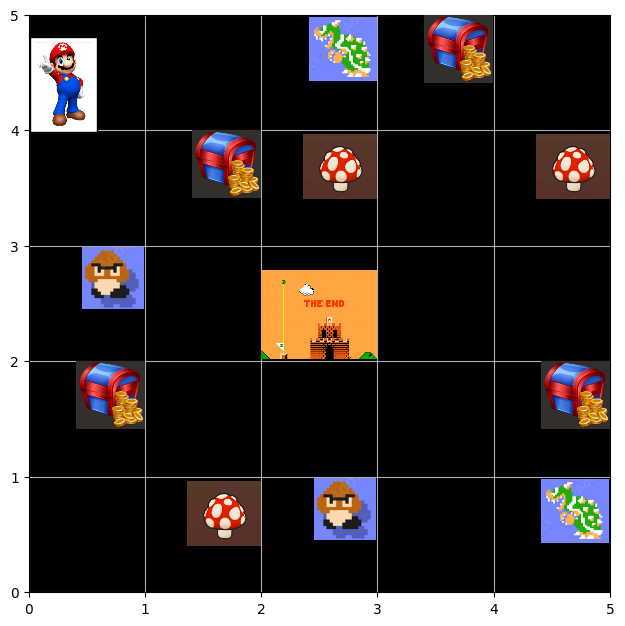

In [98]:
# Initial State Position of the Environment
env = Mario_Game_Stochastic_Environment(16) 
env.reset()
env.render()

Timestep: 1			 Performing Action: Left
Current Agent Position: [1,4] ; Current Reward: 1 ; Total Cumulative Reward: 1
Timestep: 2			 Performing Action: Down
Current Agent Position: [2,0] ; Current Reward: -5 ; Total Cumulative Reward: -4
Timestep: 3			 Performing Action: Right
Current Agent Position: [0,0] ; Current Reward: 1 ; Total Cumulative Reward: -3
Timestep: 4			 Performing Action: Down
Current Agent Position: [2,0] ; Current Reward: 1 ; Total Cumulative Reward: -2
Timestep: 5			 Performing Action: Right
Current Agent Position: [1,0] ; Current Reward: 25 ; Total Cumulative Reward: 23
Timestep: 6			 Performing Action: Left
Current Agent Position: [3,0] ; Current Reward: 1 ; Total Cumulative Reward: 24
Timestep: 7			 Performing Action: Right
Current Agent Position: [2,0] ; Current Reward: 1 ; Total Cumulative Reward: 25
Timestep: 8			 Performing Action: Down
Current Agent Position: [2,0] ; Current Reward: -1 ; Total Cumulative Reward: 24
Timestep: 9			 Performing Action: Right
Cur

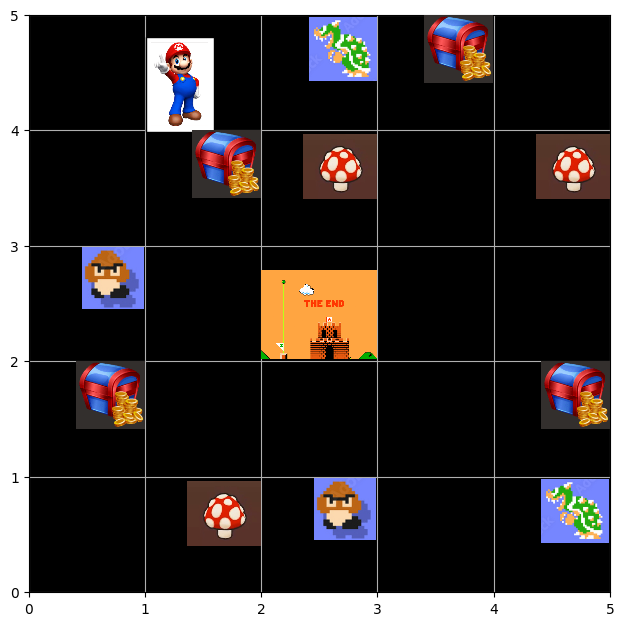

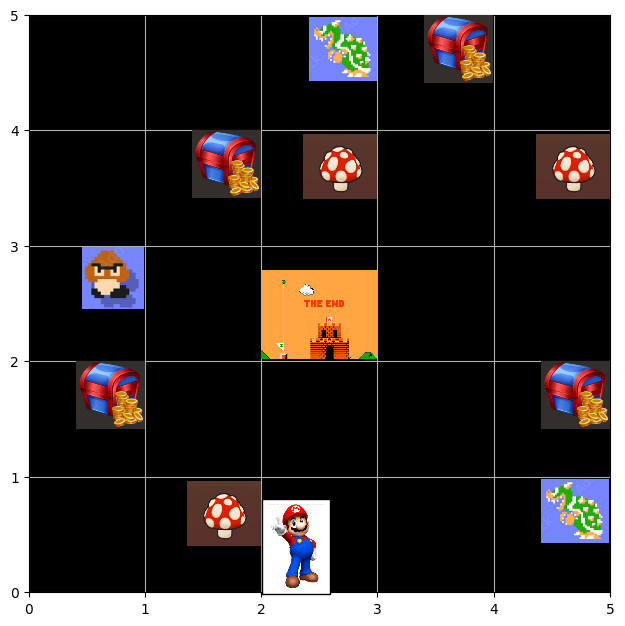

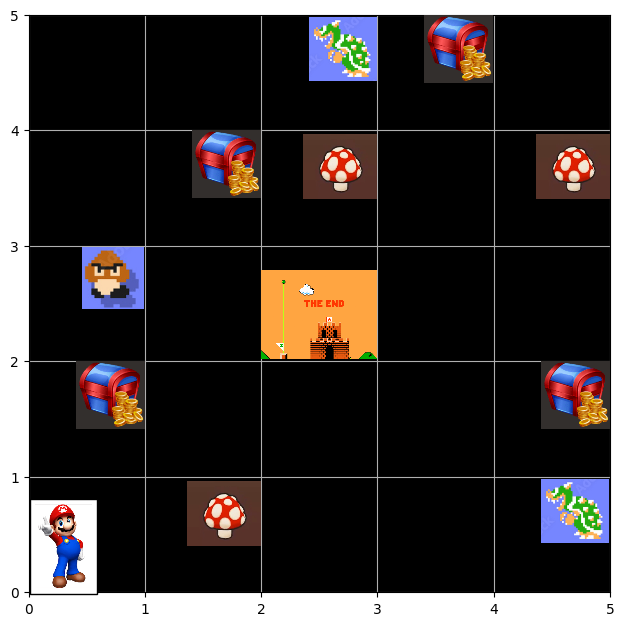

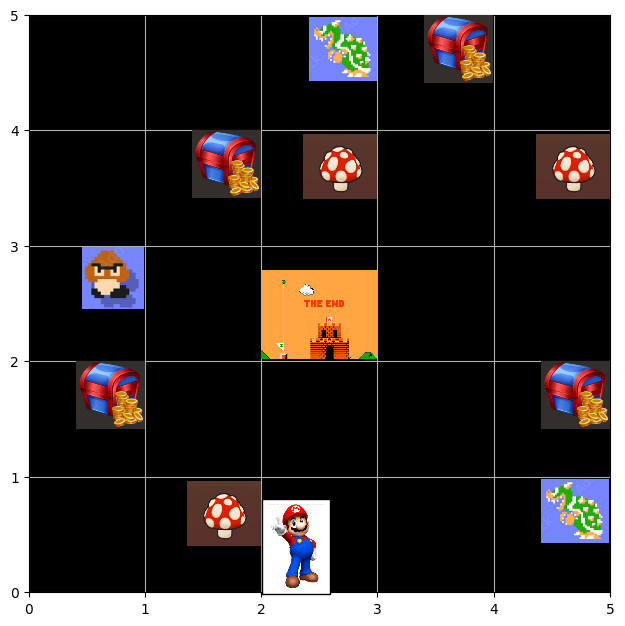

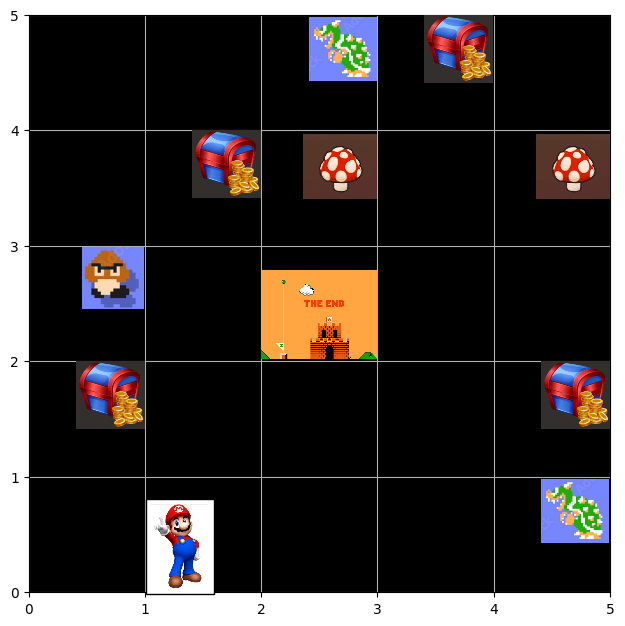

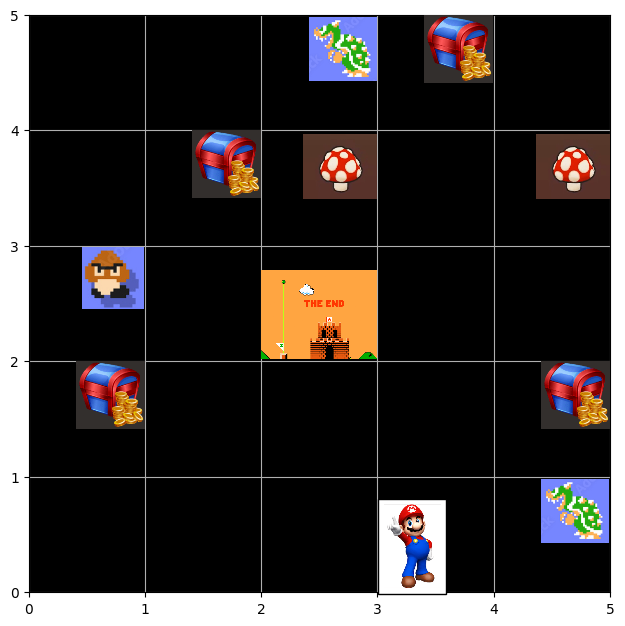

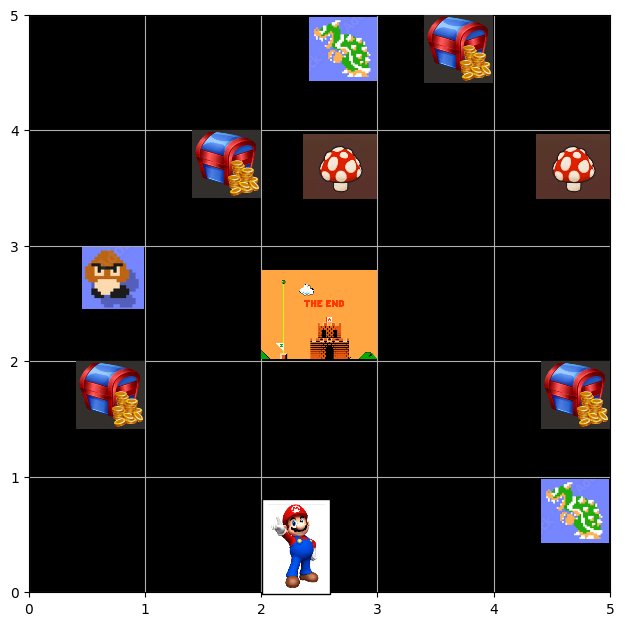

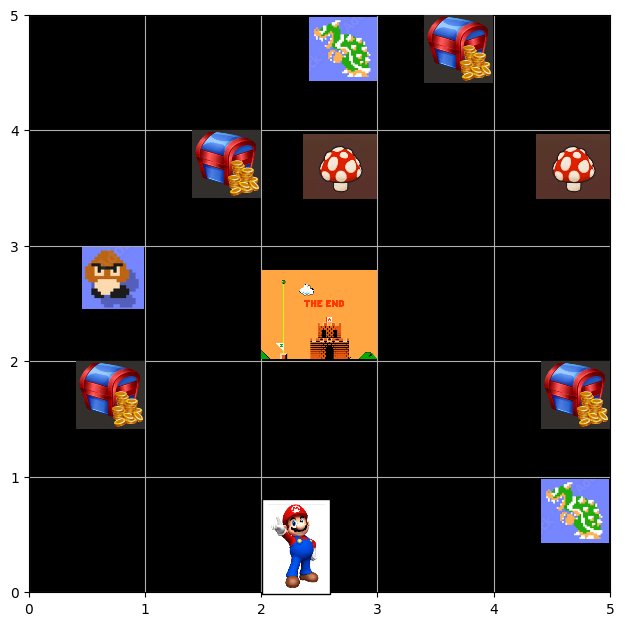

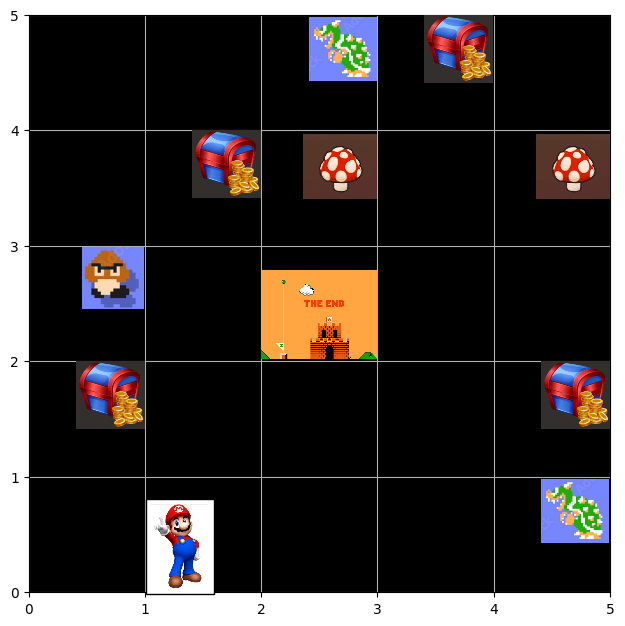

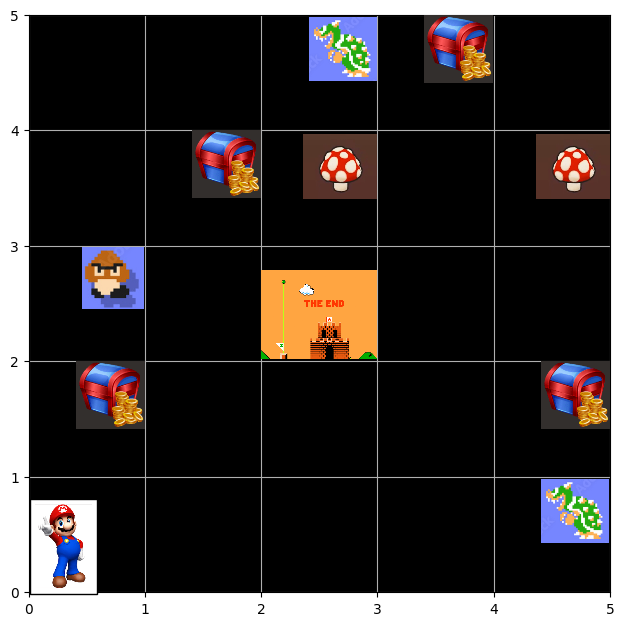

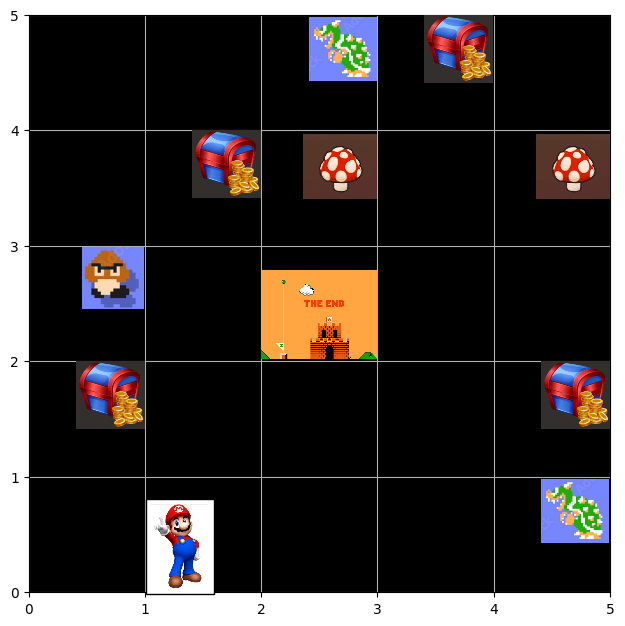

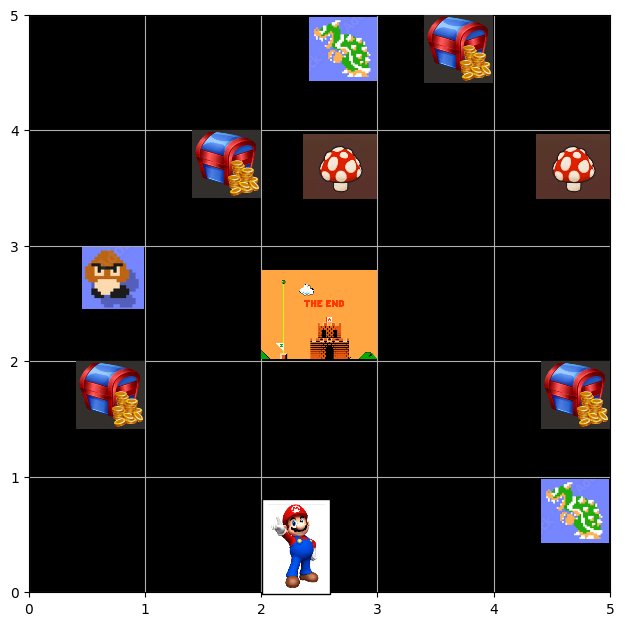

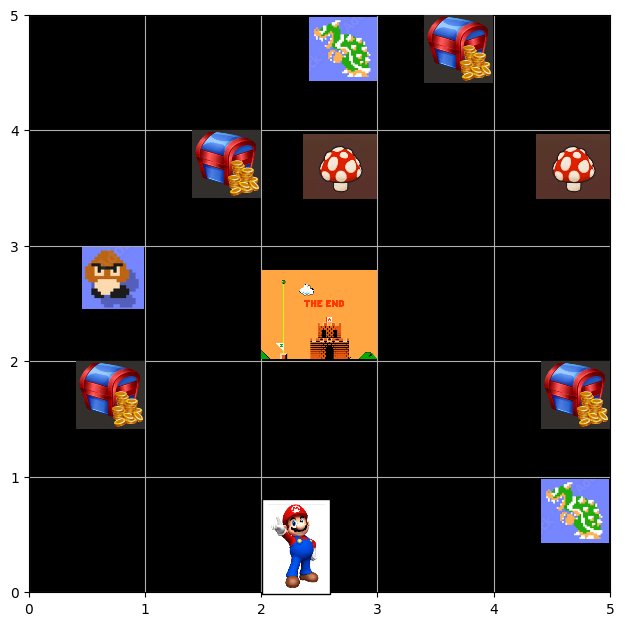

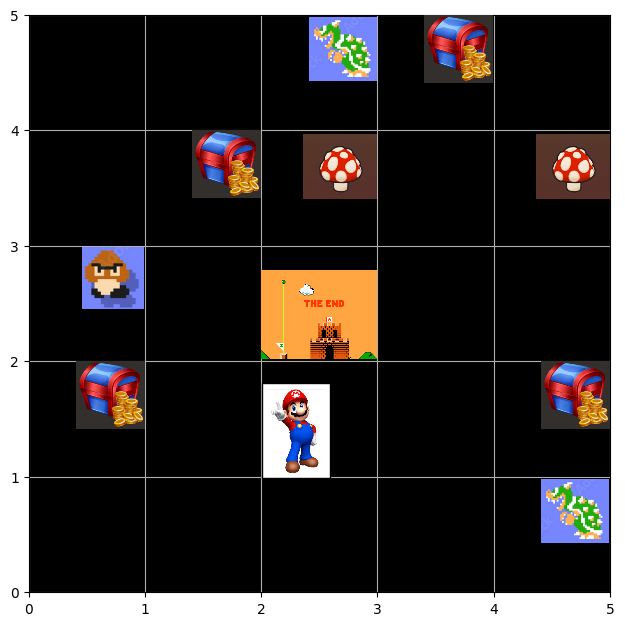

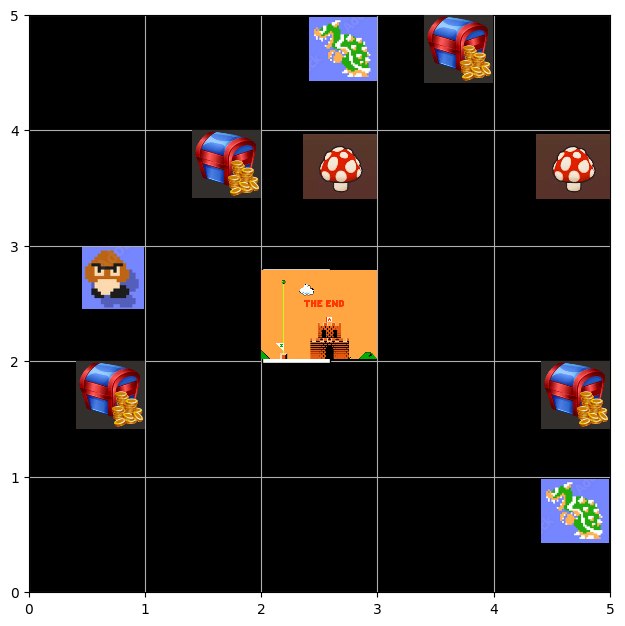

In [99]:
#Running the Mario GridWorld Game in Stochastic Environment
done = False
Actions={0:"Left",1:"Right",2:"Up",3:"Down"}
print("==================================================================================================")
while not done:
    action = random.randint(0,3)
    pos,reward, done, info = env.step(action)
    env.render()
    print("Timestep: {}".format(env.timeStep)+"\t\t\t Performing Action: "+Actions[int(action)])
    print(info)
    print("=================================================================================================")

# **2.1 Q LEARNING - STOCHASTIC ENVIRONMENT**

In [100]:
class Q_Learning_S():
    
    # Off-Policy TD Control
    # Approximates the optimal action-value function independent of the policy being followed.

    def __init__(self):
        
        #Intialising Q table with all zeros of size 5x5
        #Resetting Agent's position to Initial State
        self.Q_Table = np.zeros((25,4))
        self.a_pos=[0,4]
    
    def update_Q_table(self,state,action,reward):
        
        #Declaring metric dictionary keys
        updated_state = int(state_space[self.a_pos[0],self.a_pos[1]])
        if state==12:   #Goal State
            self.Q_Table[state,action] = 0
        else:    
            self.Q_Table[state,action] = round(self.Q_Table[state,action] + hyper_parameters['alpha']*(reward + hyper_parameters['gamma']*np.max(self.Q_Table[updated_state,:]) - self.Q_Table[state,action]),2)

    def train(self):
        env = Mario_Game_Stochastic_Environment(hyper_parameters['max_timesteps'])
        
        #Setting up keys for dictionary
        metrics['Timesteps']     = []
        metrics['Rewards']       = []
        metrics['Cumulative Rewards'] = [] 
        metrics['Epsilon Decay'] = []

        #Train - Perform Exploration & Exploitation to learn the optimal action for a current state
        for i in range(number_of_episodes): #number of episodes = 1000
            j = 100                         
            env.reset()
            #Updating learning rate gradually as the number of episodes increases
            if i%j == 0:
                hyper_parameters['alpha'] /= 10
                
            done = False
            while not done:
                state = int(state_space[self.a_pos[0],self.a_pos[1]])
                if random.random() < hyper_parameters['epsilon']:     #Random Policy - choose random action
                    action = random.randint(0,25)%4
                else:                                                 #Greedy Policy - choose optimal action
                    action = np.argmax(self.Q_Table[state,:])

                #Performing resultant action and updating Q-Table                  
                self.a_pos,reward, done, info = env.step(action)
                self.update_Q_table(state,action,reward)
              
            #Appending the key-values in metric dictionary         
            metrics['Timesteps'].append(env.timeStep)
            metrics['Rewards'].append(env.rewards)
            metrics['Cumulative Rewards'].append(env.cumulative_rewards)
            metrics['Epsilon Decay'].append(hyper_parameters['epsilon'])
            hyper_parameters['epsilon'] /= hyper_parameters['Epsilon Decay']
            self.cum_reward=metrics['Cumulative Rewards'] 
    
    def test(self,plot):
        env = Mario_Game_Stochastic_Environment(hyper_parameters['max_timesteps'])
        
        #Resetting our environment to initial state.
        env.reset()
        #Visualizing the initial state 
        env.render()
        
        metrics['Evaluation of Rewards'] = [0]
        
        done = False
        if plot:
            print("==================================================================================================")
        while not done:
            #Updating Agent's State
            state = int(state_space[env.agent_pos[0],env.agent_pos[1]])
            
            #Selecting the Optimal/Greedy Action based on our Q-Table
            action = np.argmax(self.Q_Table[state,:])                     
          
            pos,reward, done, info = env.step(action)
            metrics['Evaluation of Rewards'].append(env.cumulative_rewards)
            if (plot):
                env.render()
            
                print("Timestep: {}".format(env.timeStep)+"\tState: {}".format(state)+"\t Performing Action: "+Actions[int(action)])
                print(info)
                print("=================================================================================================")

# **2.1.1 Learning Phase - Updating Q-Table**


Q-Learning Table:

[[ 0.19  1.81 -0.15  0.2 ]
 [-0.81  0.97 -0.05  4.49]
 [ 0.47  1.25 -0.07  0.78]
 [ 0.14 -0.16 -0.04  0.02]
 [-0.04  0.51 -0.04  0.89]
 [ 3.52  0.23  0.13 -0.21]
 [ 6.38  0.65  0.47  0.27]
 [ 1.06  0.95 -0.06  7.29]
 [ 3.85  1.14  0.2   0.34]
 [-0.31  0.71  0.15  0.51]
 [ 0.24  0.46  0.16  1.02]
 [ 8.64 -0.02  0.11  0.03]
 [ 0.    0.    0.    0.  ]
 [-0.05  5.97  0.19  0.05]
 [ 0.04  0.39  2.96  0.34]
 [ 0.57  0.27 -0.82  1.92]
 [ 0.59  1.51  0.72  1.15]
 [ 0.7   0.38 11.58  0.48]
 [ 0.93  0.29  0.4   0.14]
 [-0.06  0.52  0.83 -0.62]
 [10.1   2.79  4.16  3.12]
 [ 1.14  6.77  0.93  0.65]
 [-0.36  9.4   4.89  1.32]
 [-1.84  1.76  0.32  0.09]
 [-0.07  0.75  2.27 -0.05]]


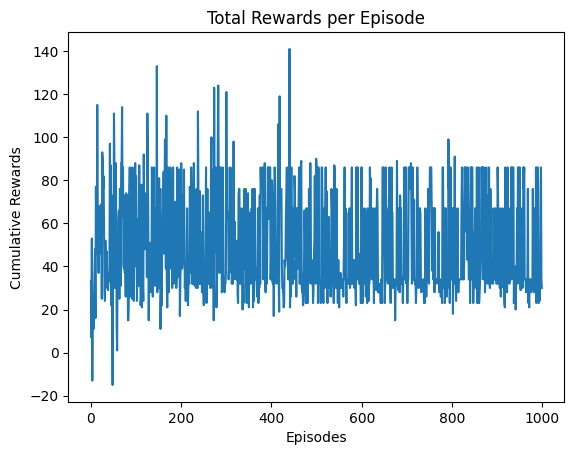

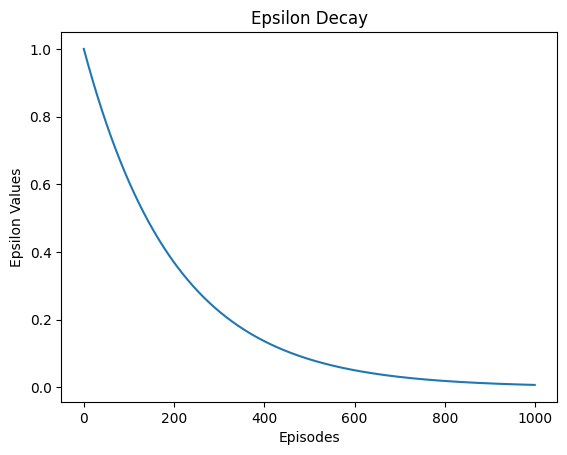

In [101]:
#Giving specific values for all the hyper parameters
hyper_parameters = {}
hyper_parameters['alpha'] = 0.2           # Learning-rate
hyper_parameters['max_timesteps'] = 100   #no. of timesteps per episode
hyper_parameters['epsilon'] = 1
hyper_parameters['Epsilon Decay'] = 1.005  #Exploration Rate  
hyper_parameters['gamma'] = 0.8          #discount-factor
number_of_episodes = 1000                 # No of episodes
metrics = {}
ql = Q_Learning_S()
ql.train()
print("\nQ-Learning Table:\n")
print(ql.Q_Table)
with open("Stochastic_Q_Learning.pkl",'wb') as f:
    pickle.dump(ql.Q_Table,f)
#Plotting all the required graphs
plt.plot(metrics['Cumulative Rewards'])
plt.title("Total Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Rewards")
plt.show()
plt.plot(metrics['Epsilon Decay'])
plt.title("Epsilon Decay")
plt.xlabel("Episodes")
plt.ylabel("Epsilon Values")
plt.show()

# **2.1.2 Testing Phase - Agent Selects Optimal Action using Q-Table**
# **and reaches GOAL POSITION**

Timestep: 1	State: 0	 Performing Action: Right
Current Agent Position: [0,0] ; Current Reward: 1 ; Total Cumulative Reward: 1
Timestep: 2	State: 20	 Performing Action: Left
Current Agent Position: [2,0] ; Current Reward: -5 ; Total Cumulative Reward: -4
Timestep: 3	State: 22	 Performing Action: Right
Current Agent Position: [0,0] ; Current Reward: 1 ; Total Cumulative Reward: -3
Timestep: 4	State: 20	 Performing Action: Left
Current Agent Position: [1,0] ; Current Reward: 25 ; Total Cumulative Reward: 22
Timestep: 5	State: 21	 Performing Action: Right
Current Agent Position: [0,0] ; Current Reward: 1 ; Total Cumulative Reward: 23
Timestep: 6	State: 20	 Performing Action: Left
Current Agent Position: [1,0] ; Current Reward: 1 ; Total Cumulative Reward: 24
Timestep: 7	State: 21	 Performing Action: Right
Current Agent Position: [0,0] ; Current Reward: 1 ; Total Cumulative Reward: 25
Timestep: 8	State: 20	 Performing Action: Left
Current Agent Position: [1,0] ; Current Reward: 1 ; Total Cu

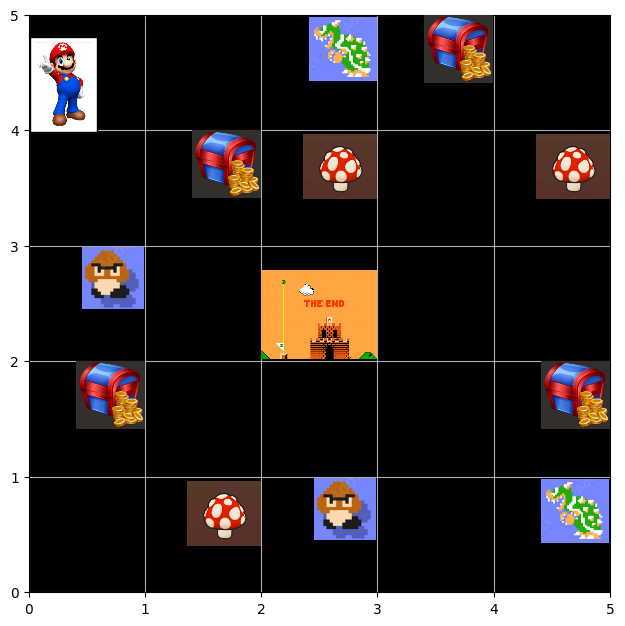

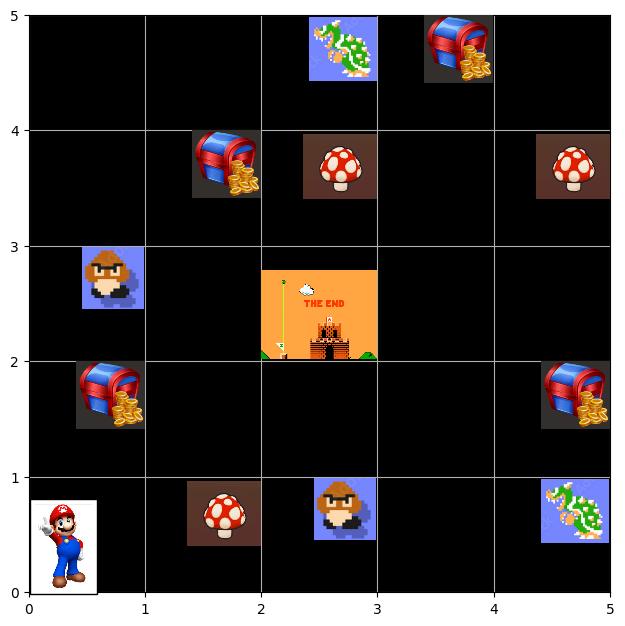

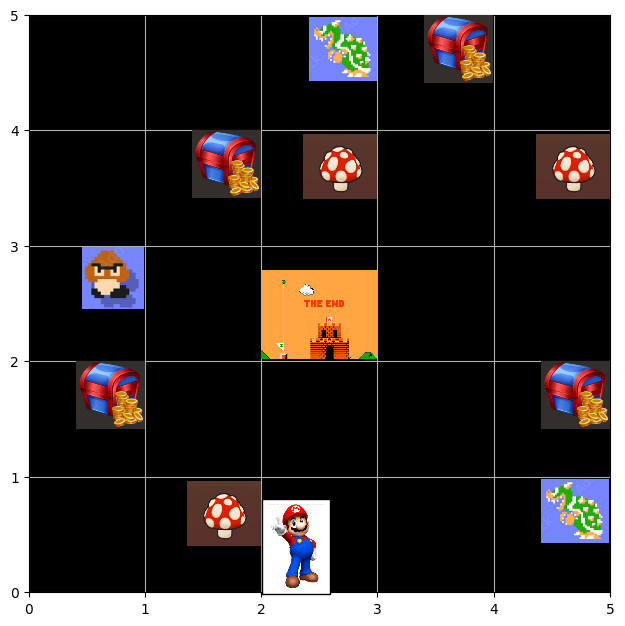

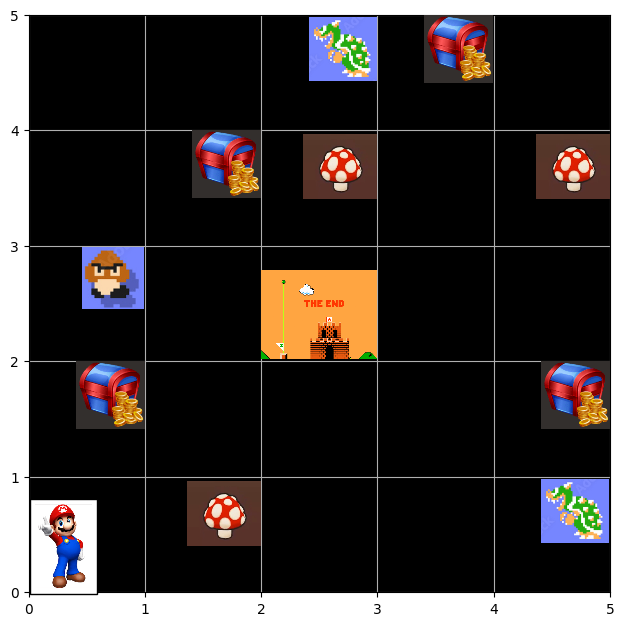

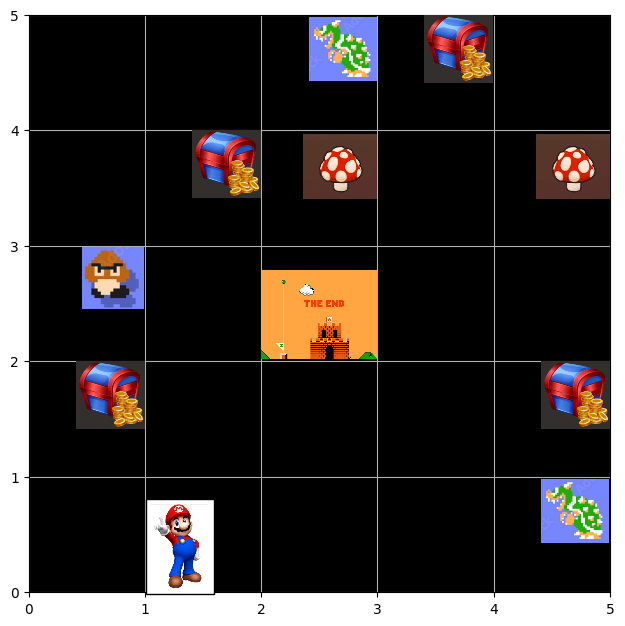

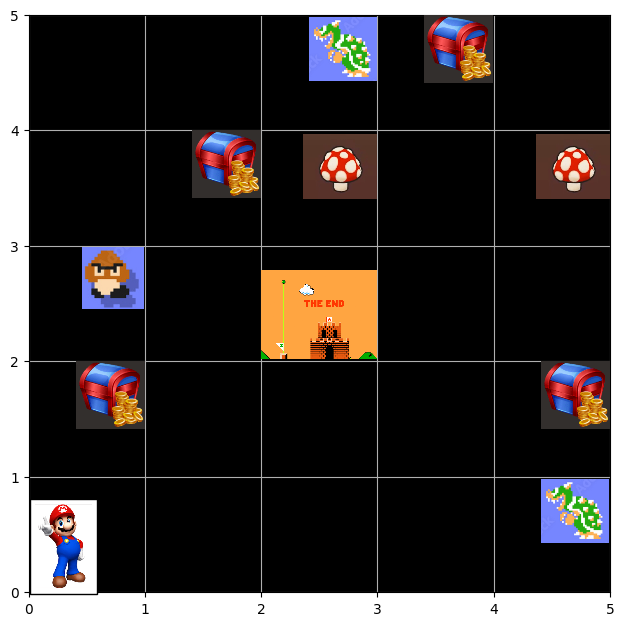

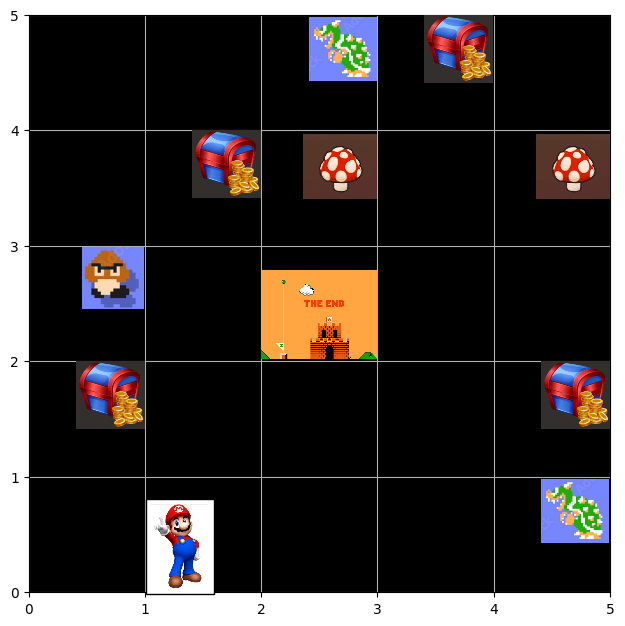

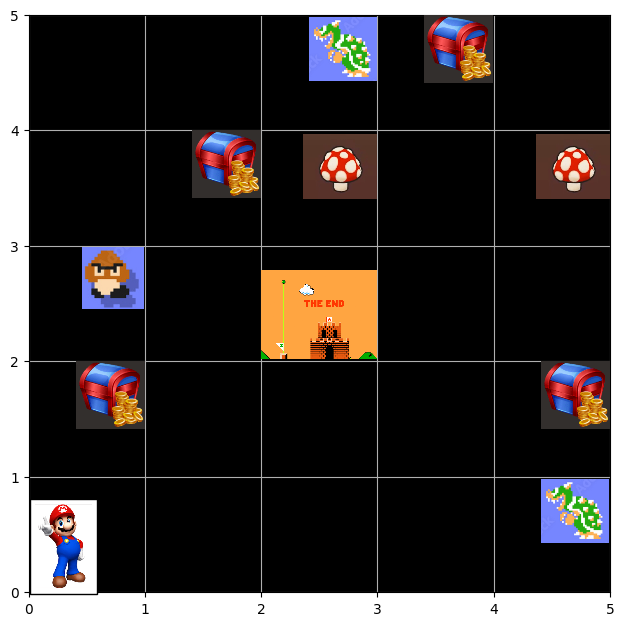

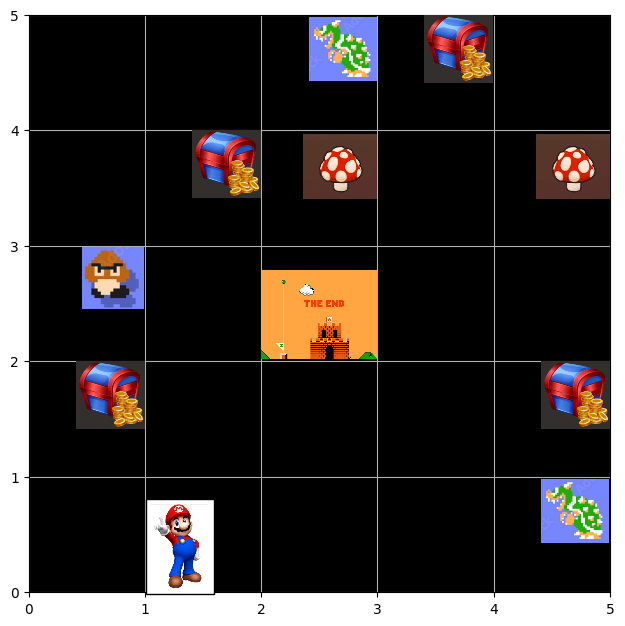

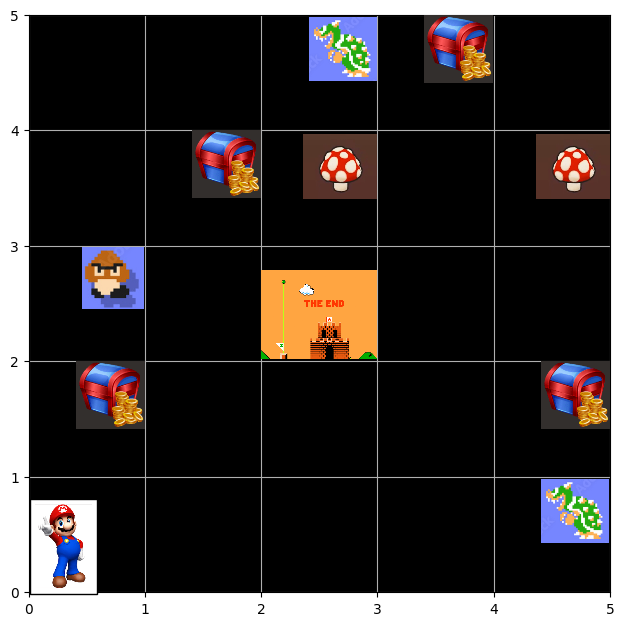

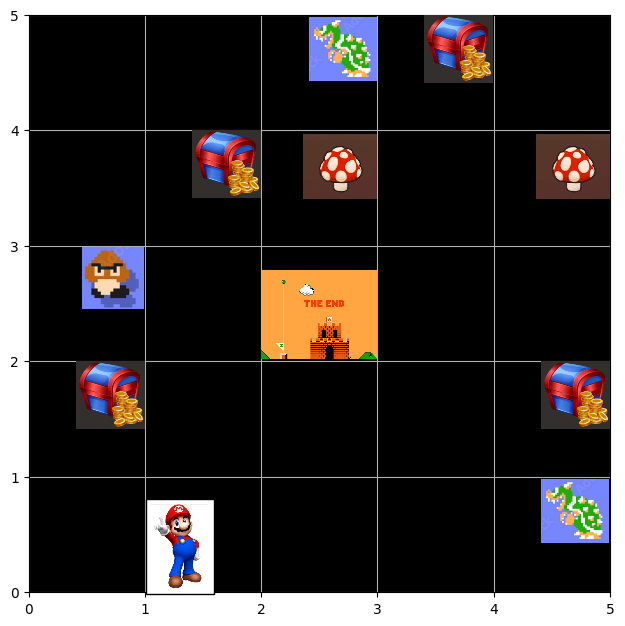

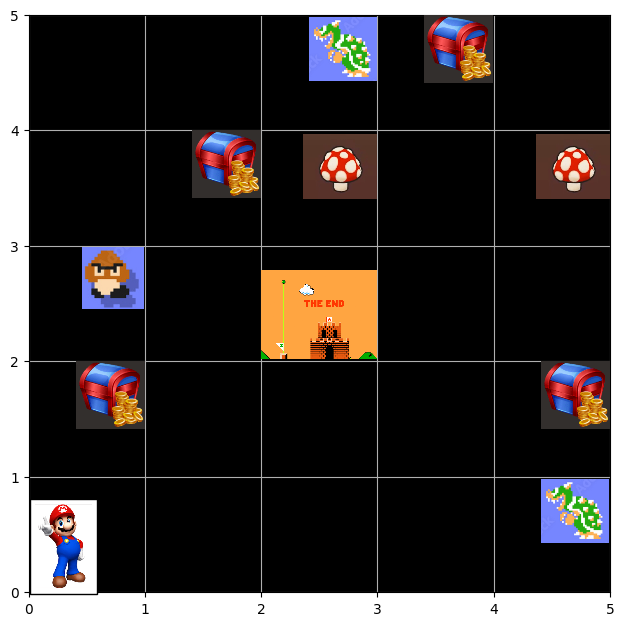

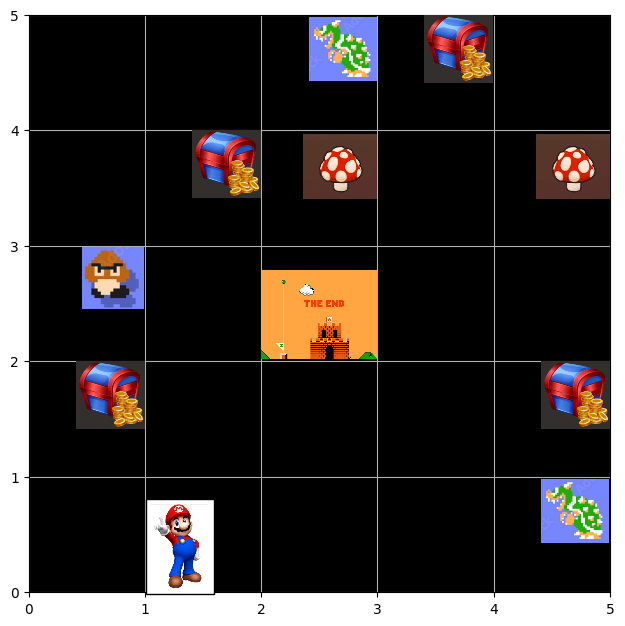

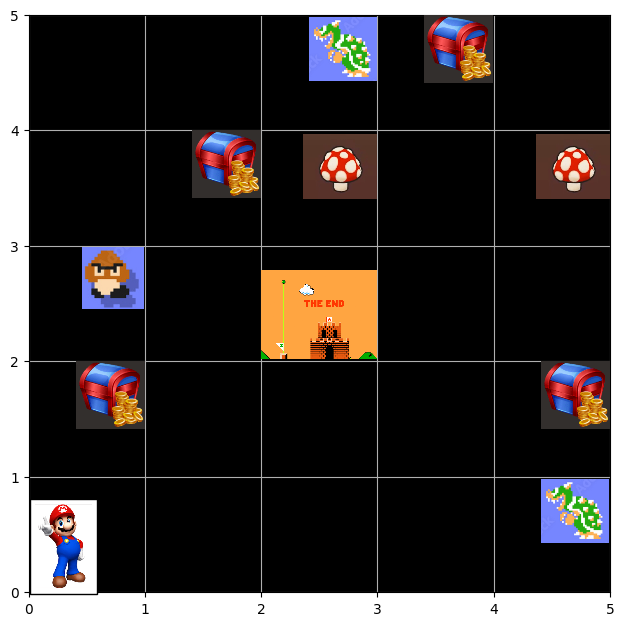

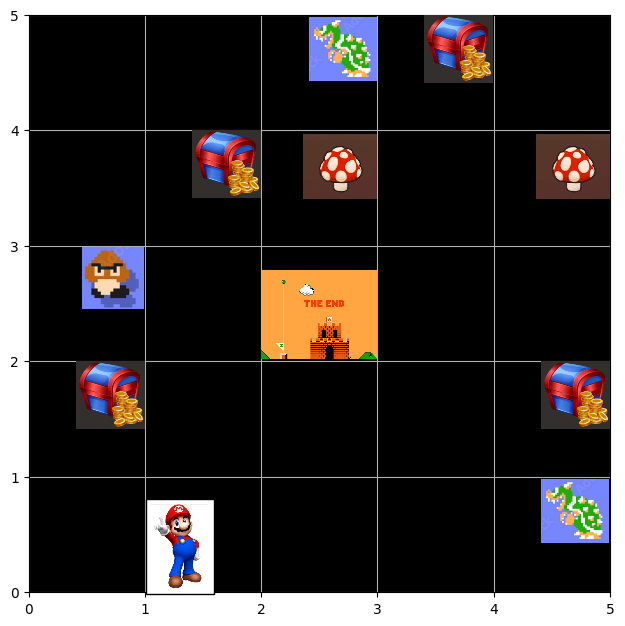

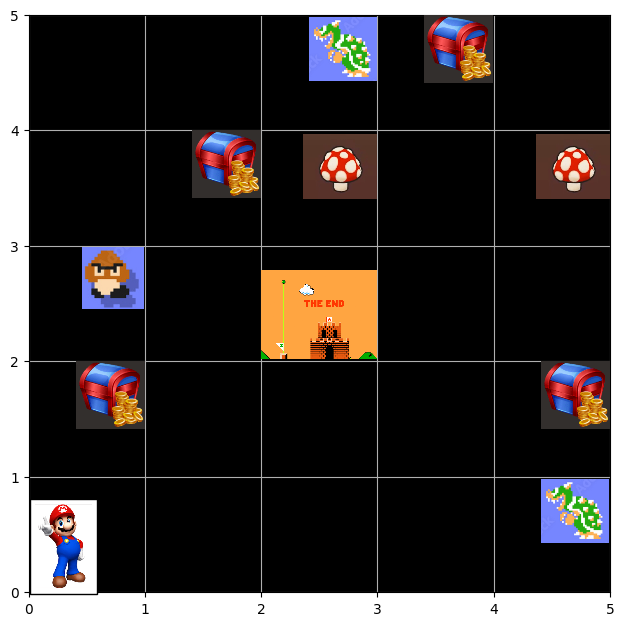

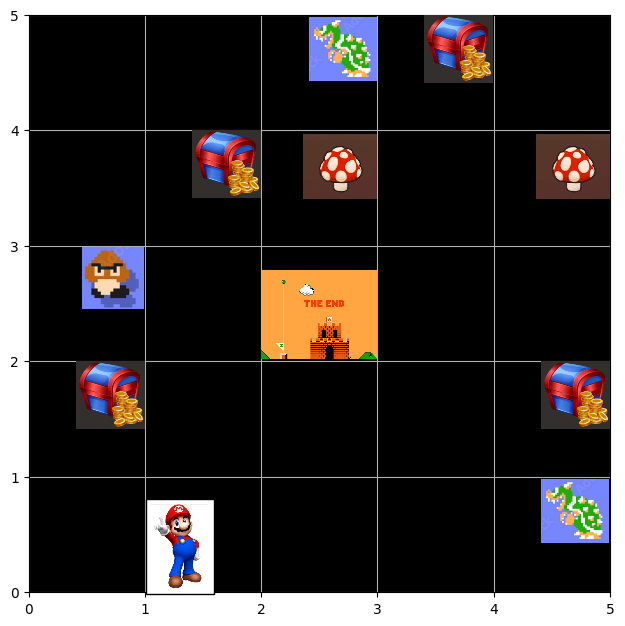

In [102]:
# Agent performing greedy actions to reach goal position State:12 Position:[2,2]
ql.test(plot=True)

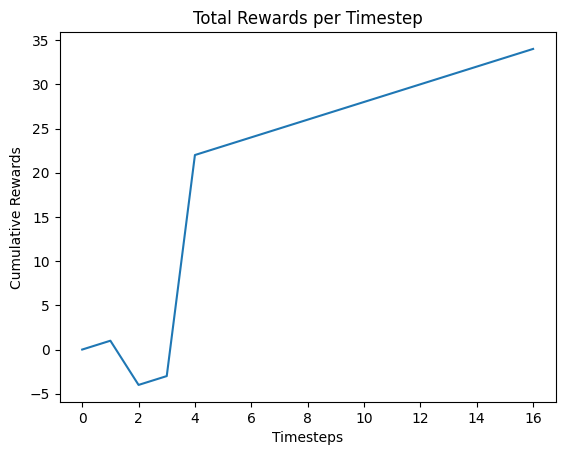

In [103]:
#Plotting Cummulative rewards as time-steps increases
metrics_ql = copy.deepcopy(metrics)
plt.plot(metrics_ql['Evaluation of Rewards'])
plt.title("Total Rewards per Timestep")
plt.xlabel("Timesteps")
plt.ylabel("Cumulative Rewards")
plt.show()

# **2.2 SARSA - STOCHASTIC ENVIRONMENT**

In [104]:
class SARSA_S():
    
    # On-Policy TD Control
    # Approximates the optimal action-value function based on the next state and action.

    def __init__(self):
        
        #Intialising Q table with all zeros of size 5x5
        #Resetting Agent's position to Initial State
        self.Q_Table = np.zeros((25,4))
        self.a_pos=[0,4]
    
    def update_Q_table(self, state, action, reward, updated_state, next_action):
        
        #Updating Q-Table using SARSA
        updated_state = int(state_space[self.a_pos[0],self.a_pos[1]])
        if state==12:   #Goal State
            self.Q_Table[state,action] = 0
        else: 
            self.Q_Table[state,action] = round(self.Q_Table[state,action] + hyper_parameters['alpha']*(reward + hyper_parameters['gamma']*self.Q_Table[updated_state,next_action] - self.Q_Table[state,action]),2)
        
    def train(self):

        env = Mario_Game_Stochastic_Environment(hyper_parameters['max_timesteps'])
        
        #Declaring metric dictionary keys
        metrics['Timesteps']     = []
        metrics['Rewards']       = []
        metrics['Cumulative Rewards'] = [] 
        metrics['Epsilon Decay'] = []

        #Train - Perform Exploration & Exploitation to learn the optimal action for a current state
        for i in range(number_of_episodes):
            j = 100
            env.reset()
            #Updating learning rate gradually as the number of episodes increases
            if i%j == 0:
                hyper_parameters['alpha'] /= 10
                
            done = False
            while not done:
                state=int(state_space[self.a_pos[0],self.a_pos[1]])
                if random.random() < hyper_parameters['epsilon']:                 #Random Policy - choose random action
                  action = random.randint(0,30)%4         
                else:                                                             #Greedy Policy - choose optimal action
                  action = np.argmax(self.Q_Table[state,:])                             
                self.a_pos,reward, done, info = env.step(action)
                updated_state = int(state_space[self.a_pos[0],self.a_pos[1]])
                if random.random() < hyper_parameters['epsilon']:                 #Random Policy - choose random action
                    next_action = random.randint(0,30)%4
                else:                                                             #Greedy Policy - choose optimal action
                    next_action = np.argmax(self.Q_Table[updated_state,:])
                self.update_Q_table(state, action, reward, updated_state, next_action)
                
            #Appending the key-values in metric dictionary        
            metrics['Timesteps'].append(env.timeStep)
            metrics['Rewards'].append(env.rewards)
            metrics['Cumulative Rewards'].append(env.cumulative_rewards)
            metrics['Epsilon Decay'].append(hyper_parameters['epsilon'])
            hyper_parameters['epsilon'] /= hyper_parameters['Epsilon Decay']
                
    def test(self):
        
        env = Mario_Game_Stochastic_Environment(hyper_parameters['max_timesteps'])
        #Resetting our environment to initial state.
        env.reset()
        #Visualizing the initial state 
        env.render()
        
        metrics['Evaluation of Rewards'] = [0]
        
        done = False
        print("==================================================================================================")
        while not done:
            #Updating Agent's State
            state = int(state_space[env.agent_pos[0],env.agent_pos[1]])
            
            #Selecting the Optimal/Greedy Action based on our Q-Table
            action = np.argmax(self.Q_Table[state,:])                     
          
            pos,reward, done, info = env.step(action)
            env.render()
            metrics['Evaluation of Rewards'].append(env.cumulative_rewards)
            
            print("Timestep: {}".format(env.timeStep)+"\tState: {}".format(state)+"\t Performing Action: "+Actions[int(action)])
            print(info)
            print("=================================================================================================")

# **2.2.1 Learning Phase - Updating Q-Table**

[[-1.700e-01  9.300e-01 -3.300e-01 -3.100e-01]
 [-2.100e-01  1.210e+00 -1.800e-01  3.800e-01]
 [ 1.000e+00  4.300e-01  1.000e-02  3.900e+00]
 [ 2.200e-01  2.000e-02 -1.600e-01 -5.000e-02]
 [-1.300e-01  3.400e-01 -1.400e-01  1.120e+00]
 [ 2.260e+00  7.000e-02  2.000e-02 -1.300e-01]
 [ 3.560e+00  1.600e-01  6.000e-02 -5.000e-02]
 [ 1.510e+00  5.600e-01 -2.200e-01  3.320e+00]
 [ 7.700e-01  1.000e-01  4.200e-01  2.000e-02]
 [-8.000e-02  4.000e-01  8.000e-02  5.000e-02]
 [ 3.100e+00  6.000e-02  2.000e-02  2.300e-01]
 [ 6.460e+00  1.100e-01  9.200e-01  1.200e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 4.000e-02  1.190e+00  0.000e+00 -8.000e-02]
 [-1.000e-02  5.000e-02  1.110e+00 -1.000e-01]
 [ 3.700e-01 -1.000e-02 -5.600e-01  1.290e+00]
 [ 4.700e-01  1.640e+00  9.900e-01  5.200e-01]
 [ 2.400e-01  3.300e-01  1.528e+01  3.000e-01]
 [ 1.730e+00  6.200e-01  1.200e-01  2.100e-01]
 [-2.800e-01  4.200e-01  1.300e-01 -3.700e-01]
 [ 8.070e+00  1.910e+00  4.520e+00  1.360e+00]
 [ 5.200e-01 

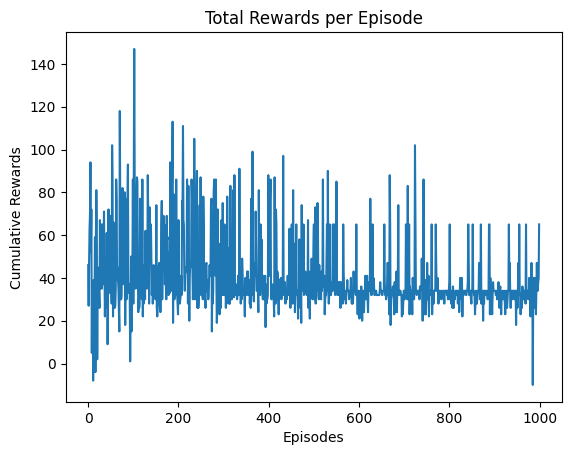

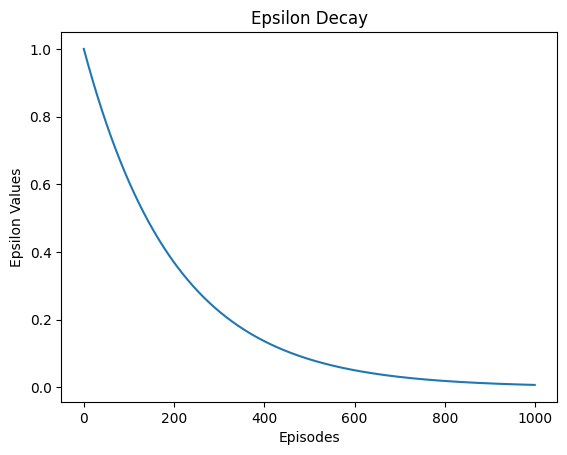

In [105]:
#Giving specific values for all the hyper parameters
hyper_parameters = {}
hyper_parameters['alpha'] = 0.2
hyper_parameters['max_timesteps'] = 100
hyper_parameters['epsilon'] = 1
hyper_parameters['Epsilon Decay'] = 1.005
hyper_parameters['gamma'] = 0.8
number_of_episodes = 1000
metrics = {}
metrics['Epsilon Decay'] = []
sa = SARSA_S()
sa.train()
print(sa.Q_Table)
with open("Stochastic_SARSA.pkl",'wb') as f:
    pickle.dump(sa.Q_Table,f)
#Plotting all the required graphs
plt.plot(metrics['Cumulative Rewards'])
plt.title("Total Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Rewards")
plt.show()
plt.plot(metrics['Epsilon Decay'])
plt.title("Epsilon Decay")
plt.xlabel("Episodes")
plt.ylabel("Epsilon Values")
plt.show()

# **2.2.2 Testing Phase - Agent Selects Optimal Action using Q-Table**
# **and reaches GOAL POSITION**

Timestep: 1	State: 0	 Performing Action: Right
Current Agent Position: [0,4] ; Current Reward: -1 ; Total Cumulative Reward: -1
Timestep: 2	State: 0	 Performing Action: Right
Current Agent Position: [0,0] ; Current Reward: 1 ; Total Cumulative Reward: 0
Timestep: 3	State: 20	 Performing Action: Left
Current Agent Position: [1,0] ; Current Reward: 25 ; Total Cumulative Reward: 25
Timestep: 4	State: 21	 Performing Action: Right
Current Agent Position: [0,0] ; Current Reward: 1 ; Total Cumulative Reward: 26
Timestep: 5	State: 20	 Performing Action: Left
Current Agent Position: [1,0] ; Current Reward: 1 ; Total Cumulative Reward: 27
Timestep: 6	State: 21	 Performing Action: Right
Current Agent Position: [0,0] ; Current Reward: 1 ; Total Cumulative Reward: 28
Timestep: 7	State: 20	 Performing Action: Left
Current Agent Position: [1,0] ; Current Reward: 1 ; Total Cumulative Reward: 29
Timestep: 8	State: 21	 Performing Action: Right
Current Agent Position: [0,0] ; Current Reward: 1 ; Total Cu

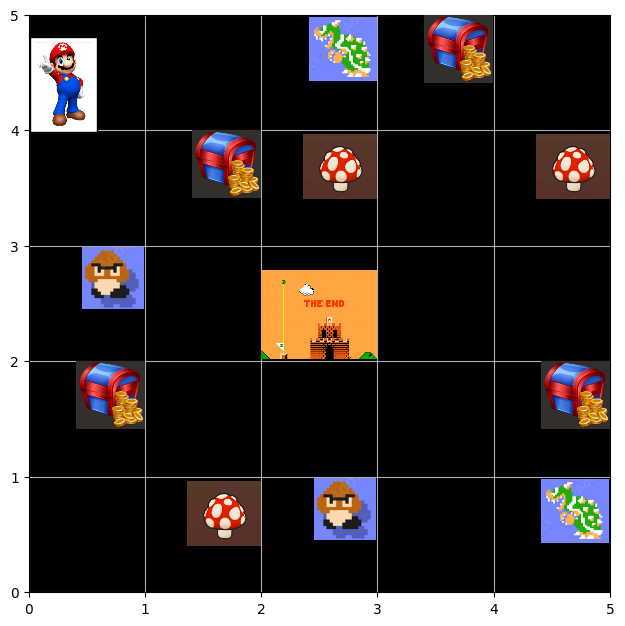

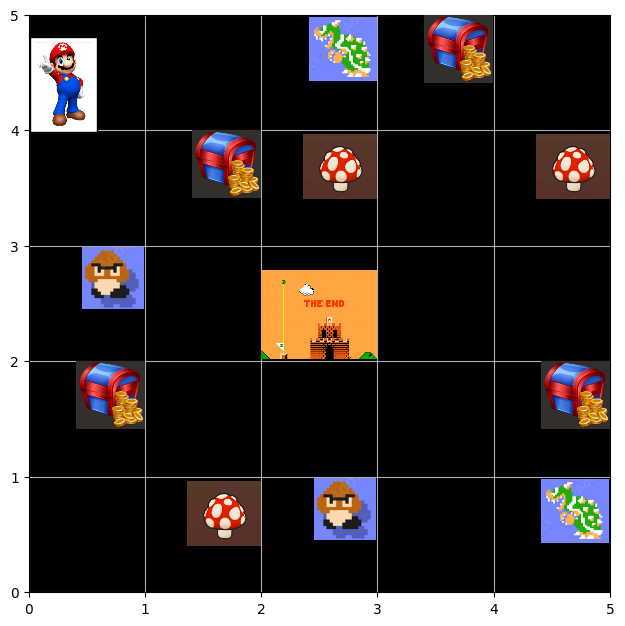

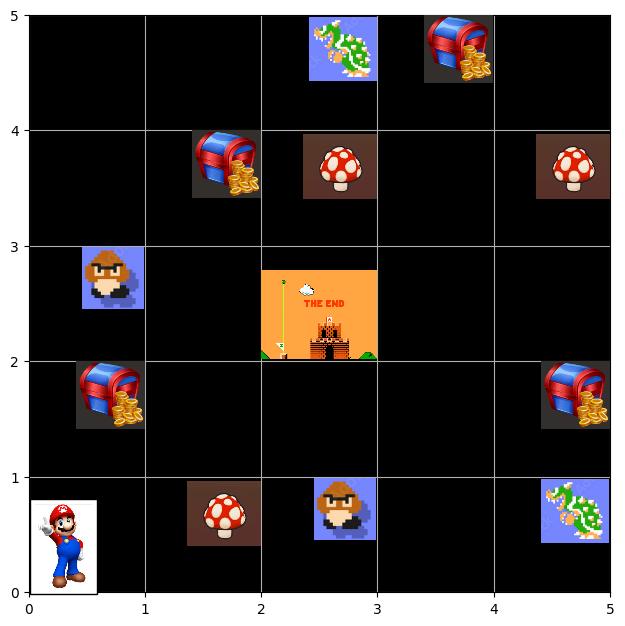

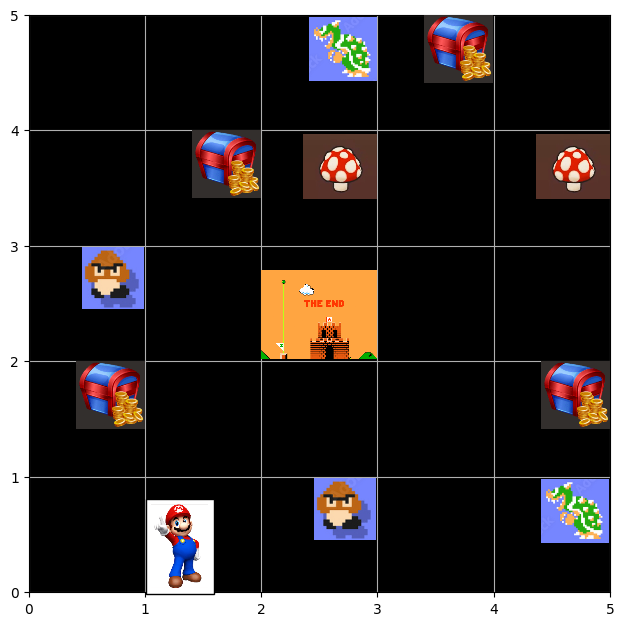

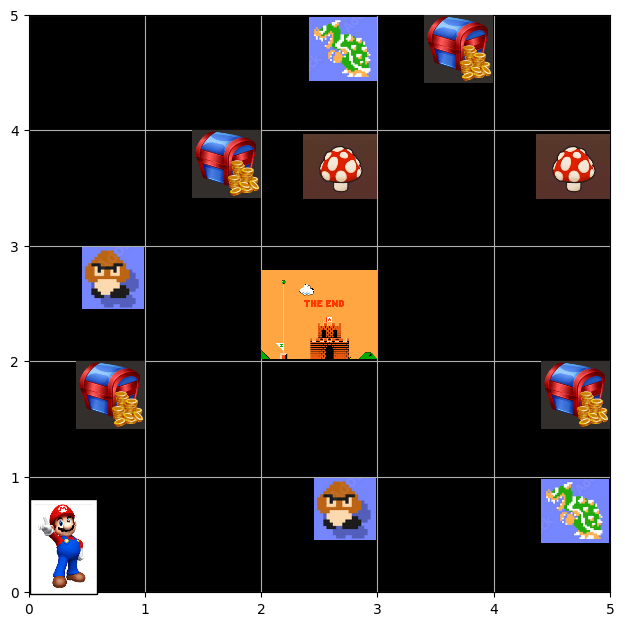

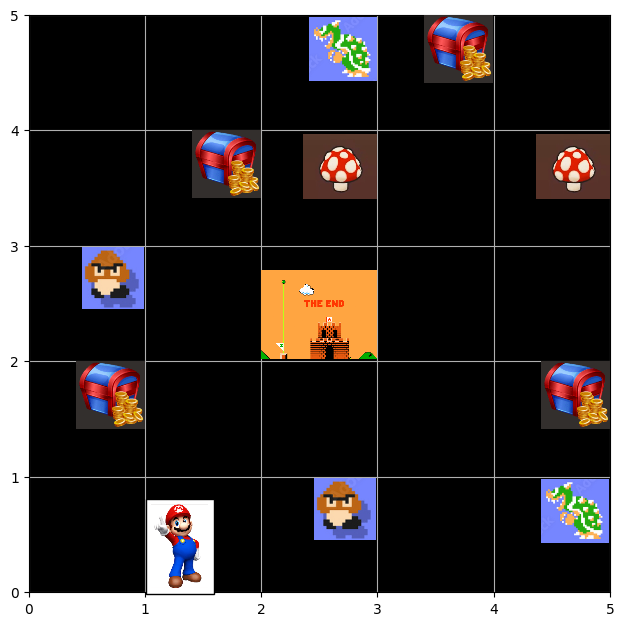

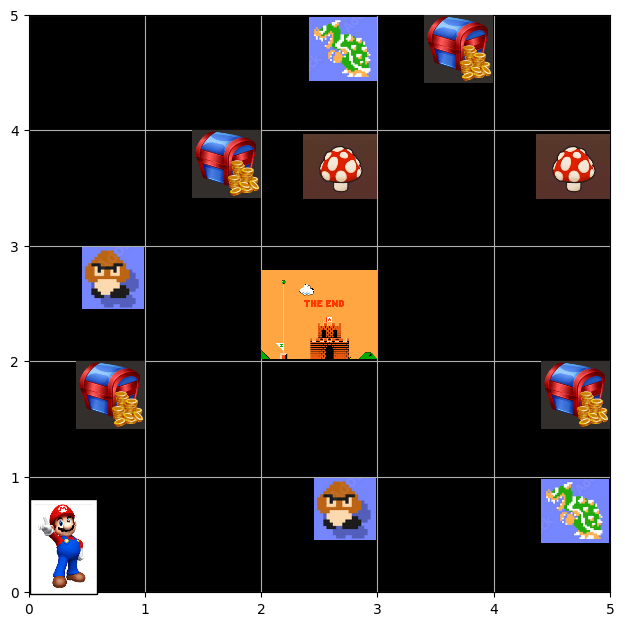

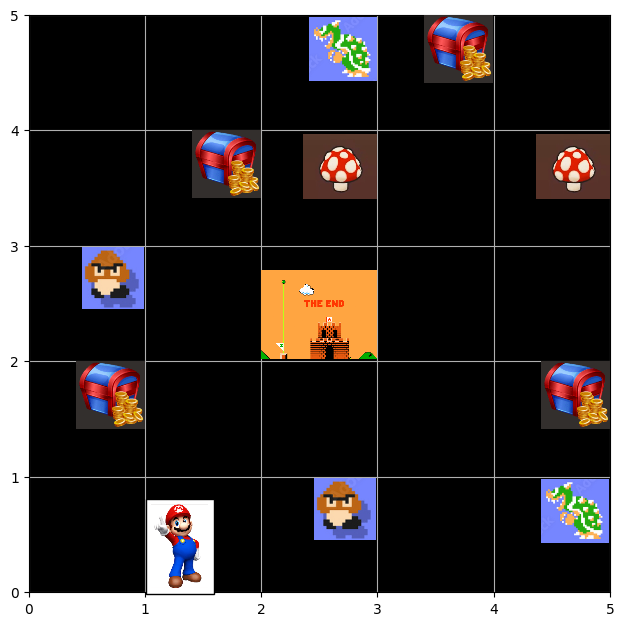

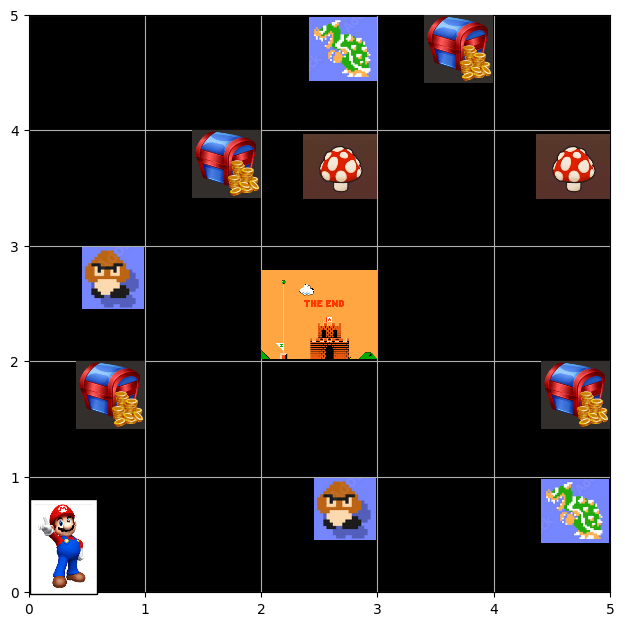

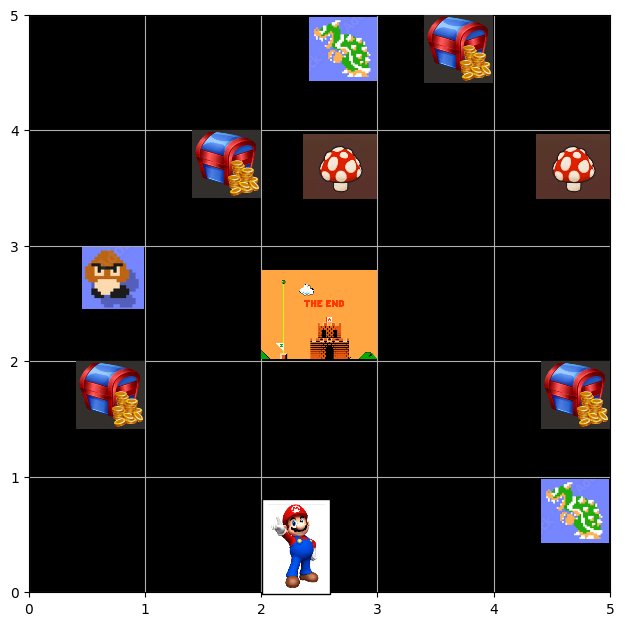

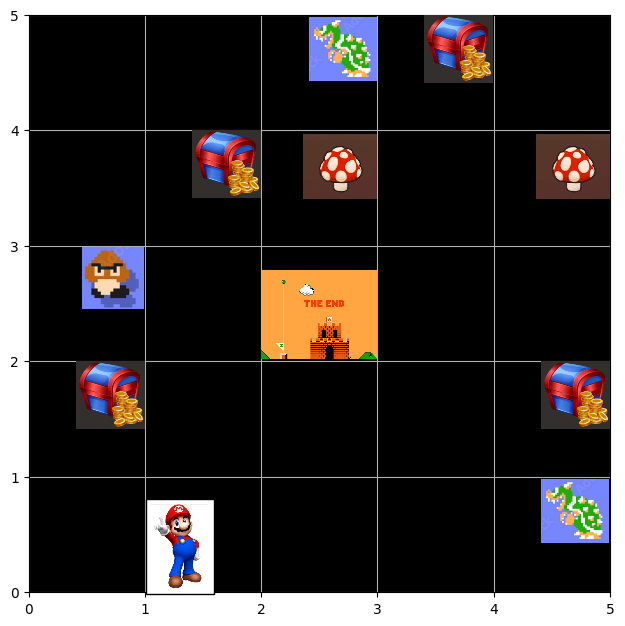

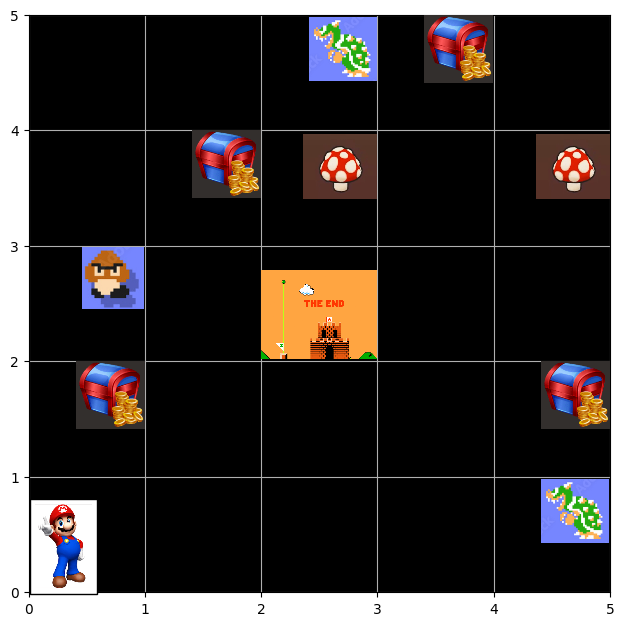

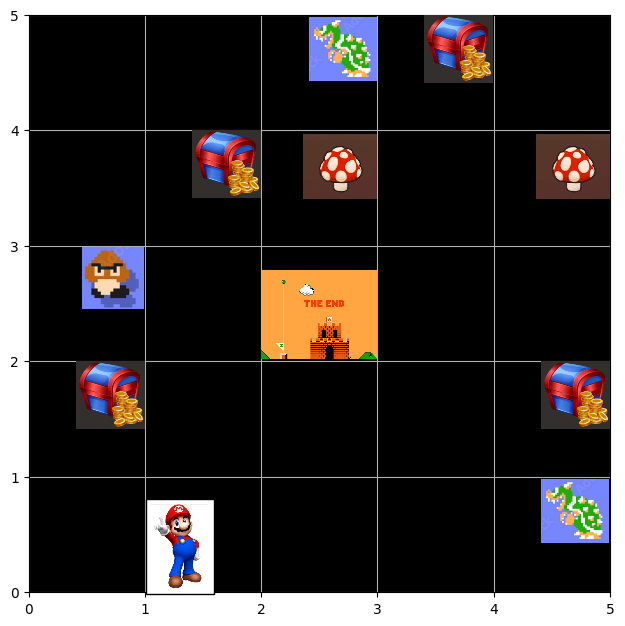

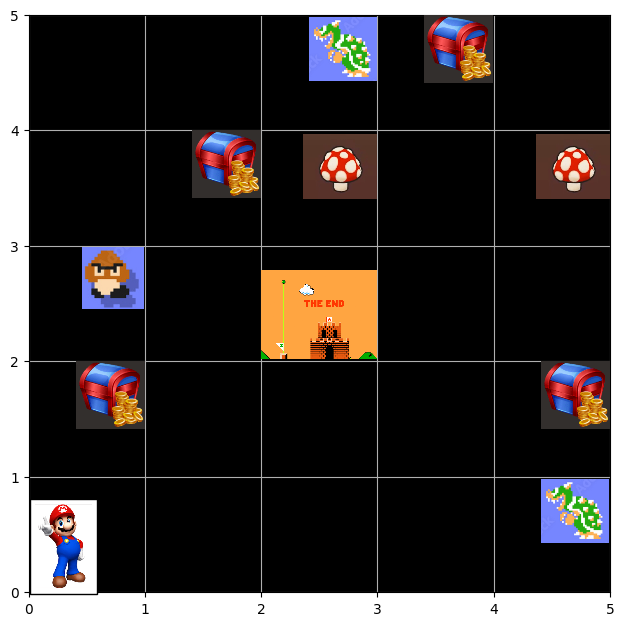

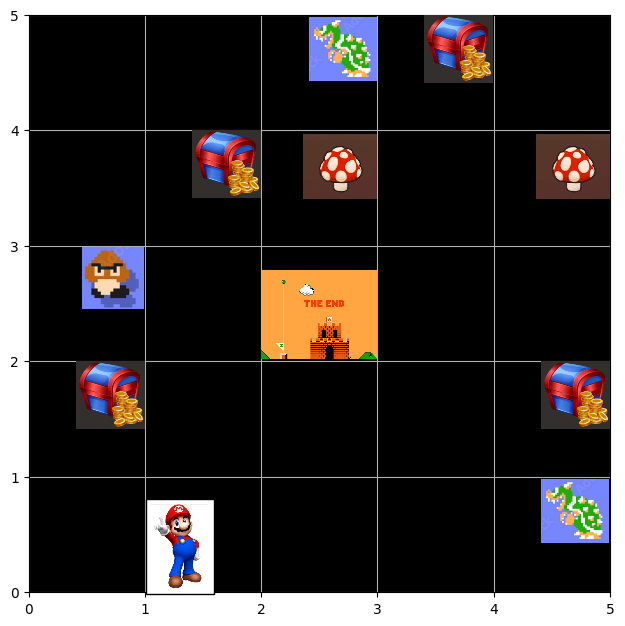

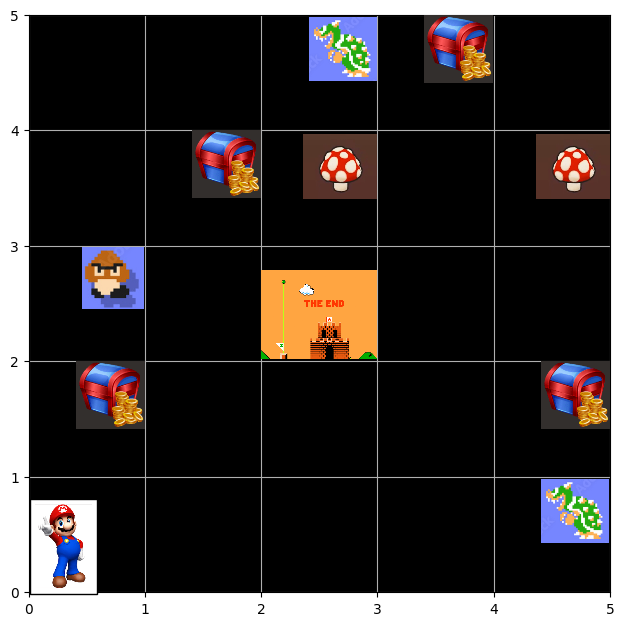

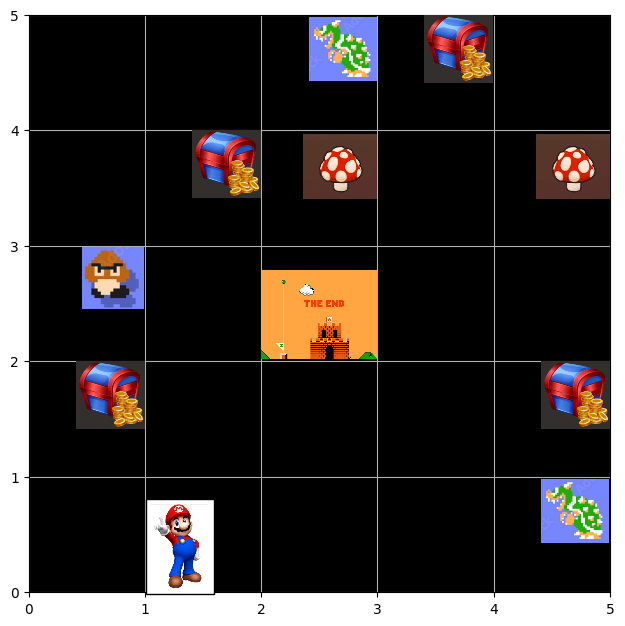

In [106]:
# Agent performing greedy actions to reach goal position State:12 Position:[2,2]
sa.test()

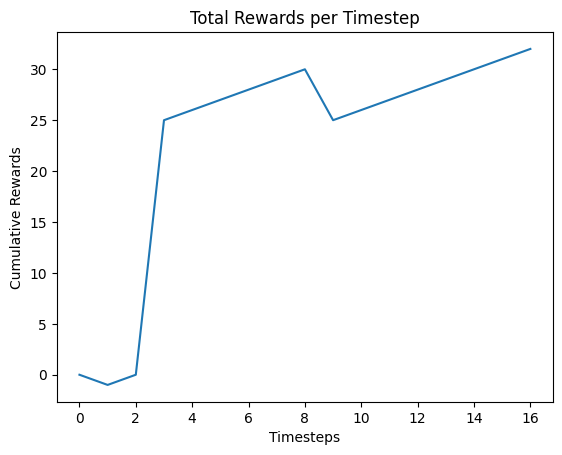

In [107]:
#Plotting Cummulative rewards as time-steps increases
metrics_sa = copy.deepcopy(metrics)
plt.plot(metrics_sa['Evaluation of Rewards'])
plt.title("Total Rewards per Timestep")
plt.xlabel("Timesteps")
plt.ylabel("Cumulative Rewards")
plt.show()

# **2.3 Comparing Q-Learning And SARSA - STOCHASTIC ENVIRONMENT**

Text(0.5, 0.01, 'Q-Learning : Blue, SARSA : Orange')

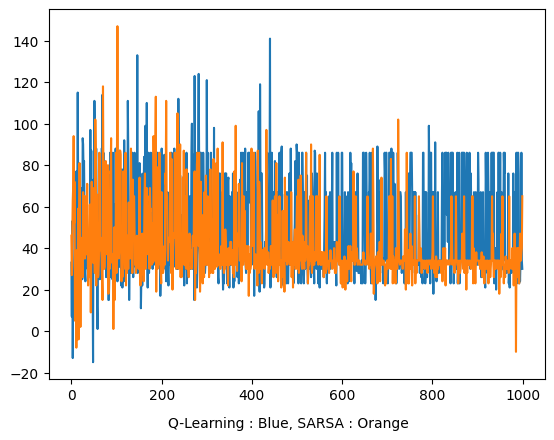

In [108]:
#Comparing the Q-learing and SARSA Cummulative Rewards
plt.plot(metrics_ql['Cumulative Rewards'],markersize=5)
plt.plot(metrics_sa['Cumulative Rewards'],markersize=5)
plt.figtext(0.5, 0.01, "Q-Learning : Blue, SARSA : Orange", horizontalalignment='center')

# **2.4 Hyperparameter Tuning - STOCHASTIC ENVIRONMENT**

# **2.4.1 Tuning Discount Factor - 0.7 ,0.8, 0.9**


Q-Learning Table:

[[-0.48  1.55 -0.15  0.59]
 [-0.79  1.04 -0.04  2.81]
 [ 1.04  0.49 -0.02  5.26]
 [ 0.27  0.17 -0.13  0.12]
 [-0.1   0.86 -0.11  0.44]
 [ 5.27  0.63  0.15 -0.33]
 [ 6.77  0.44  0.23  0.23]
 [ 1.61  1.22  0.15 12.95]
 [ 0.6   2.17  0.85 -0.02]
 [-0.03  0.22  0.06  0.04]
 [ 3.5   0.38  0.08  0.29]
 [ 7.88 -0.02  0.5   0.  ]
 [ 0.    0.    0.    0.  ]
 [ 0.    2.37  0.14  0.02]
 [-0.04  0.17  0.5   0.29]
 [ 0.87  0.39 -0.58  0.22]
 [ 0.8   0.78  0.35  2.21]
 [ 0.87  0.43 10.64  0.29]
 [ 1.23  0.32  0.14  0.12]
 [-0.04  0.61  0.06 -0.21]
 [ 9.    3.25  4.58  2.51]
 [ 1.16  4.9   0.56  0.46]
 [-0.14  8.31  3.69  0.88]
 [-1.89  1.38  0.2  -0.06]
 [-0.19  0.49  1.56 -0.02]]


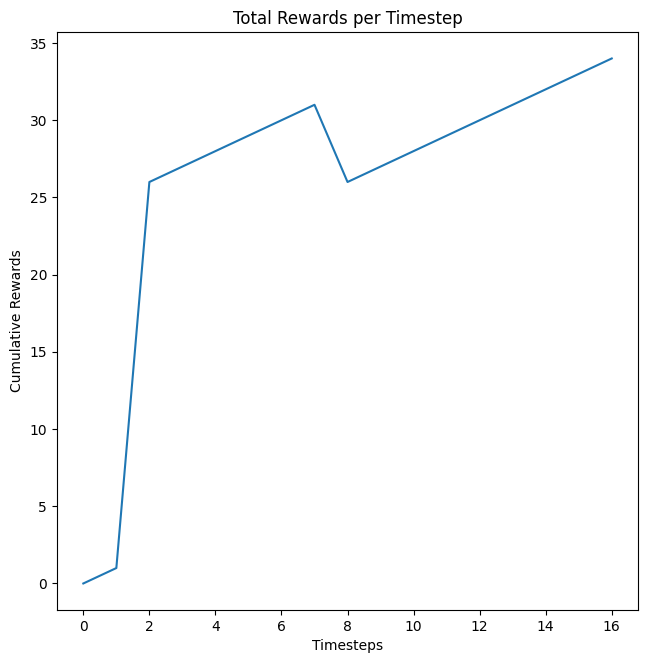


Q-Learning Table:

[[-6.600e-01  2.040e+00 -1.300e-01  4.200e-01]
 [-1.160e+00  2.380e+00 -1.000e-01  7.200e-01]
 [ 2.240e+00  3.900e-01 -4.000e-02  1.610e+00]
 [ 2.600e-01  2.100e-01 -6.000e-02 -1.000e-02]
 [-4.000e-02  4.800e-01 -8.000e-02  1.200e+00]
 [ 3.930e+00  3.000e-01  1.400e-01 -5.700e-01]
 [ 3.990e+00  5.400e-01  2.700e-01  1.000e-01]
 [ 5.400e-01  6.500e-01 -1.800e-01  4.540e+00]
 [ 7.100e-01  5.400e-01  2.400e-01  4.000e-02]
 [-0.000e+00  3.000e-01  0.000e+00  0.000e+00]
 [ 2.900e-01  9.800e-01  1.500e-01  5.600e-01]
 [ 7.590e+00  5.000e-02  6.700e-01  9.000e-02]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 7.000e-02  5.400e-01  2.000e-02  1.000e-01]
 [-2.000e-02  3.200e-01  0.000e+00  2.000e-02]
 [ 7.200e-01  6.100e-01 -7.300e-01  3.010e+00]
 [ 1.440e+00  2.230e+00  7.600e-01  1.030e+00]
 [ 2.900e-01  9.500e-01  1.731e+01  8.300e-01]
 [ 1.380e+00  7.600e-01  1.400e-01  8.000e-02]
 [-4.000e-02  5.000e-01  2.000e-02 -3.500e-01]
 [ 1.130e+01  3.220e+00  5.300e+00  3.31

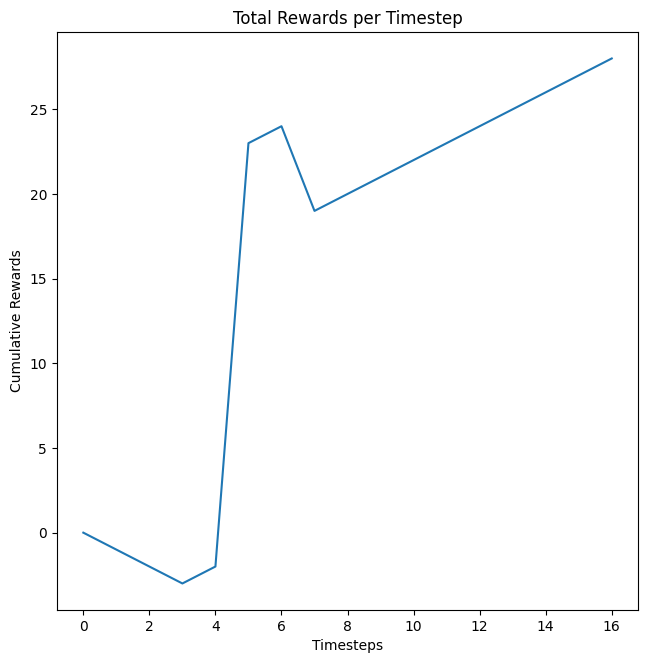


Q-Learning Table:

[[-0.2   2.22 -0.15  0.76]
 [-0.39  2.74 -0.05  1.16]
 [ 0.98  0.61  0.06  4.57]
 [ 0.12  0.22 -0.03  0.1 ]
 [-0.02  0.68 -0.04  1.54]
 [ 4.38  0.24  0.23 -0.28]
 [ 4.6   0.23  0.09  0.02]
 [ 1.25  0.6  -0.31  8.92]
 [ 2.49  0.66  0.42  0.02]
 [-0.06  1.16  0.09  0.12]
 [ 2.31  0.2   0.16  0.4 ]
 [ 5.62 -0.13  0.25  0.04]
 [ 0.    0.    0.    0.  ]
 [ 0.13  0.46  0.04  0.05]
 [ 0.02  0.32  1.57  0.18]
 [ 0.35  0.83 -0.57  1.9 ]
 [ 0.69  0.92  0.31  1.56]
 [ 1.2   0.66 10.03  0.65]
 [ 1.67  0.4   0.06  0.32]
 [-0.08  1.16  0.12 -0.61]
 [12.18  4.42  5.03  3.69]
 [ 1.75  9.01  0.62  0.97]
 [-0.27  9.88  4.8   1.29]
 [-1.37  1.9   0.24  0.14]
 [-0.17  0.4   1.33 -0.04]]


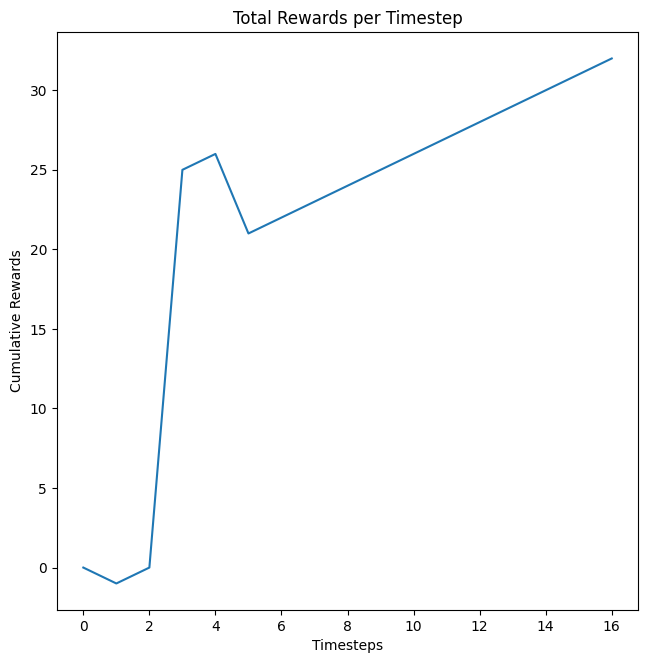

In [109]:
#Giving specific values for all the hyper parameters
for gamma in [0.7,0.8,0.9]:
    hyper_parameters = {}
    hyper_parameters['alpha'] = 0.2           # Learning-rate
    hyper_parameters['max_timesteps'] = 100   #no. of timesteps per episode
    hyper_parameters['epsilon'] = 1
    hyper_parameters['Epsilon Decay'] = 1.005  #Exploration Rate  
    hyper_parameters['gamma'] = gamma          #discount-factor
    number_of_episodes = 1000                 # No of episodes
    metrics = {}
    ql = Q_Learning_S()
    ql.train()
    print("\nQ-Learning Table:\n")
    print(ql.Q_Table)
    #Plotting all the required graphs
    ql.test(plot=False)
    plt.clf()
    plt.plot(metrics['Evaluation of Rewards'])
    plt.title("Total Rewards per Timestep")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Rewards")
    plt.show()


# **2.4.1 Learning rate - 0.1 ,0.15, 0.2**


Q-Learning Table:

[[-0.47  0.62 -0.13  0.03]
 [-1.04  0.29 -0.08  2.04]
 [ 0.83  0.15 -0.01  2.25]
 [ 0.13  0.09 -0.04  0.06]
 [-0.    0.63 -0.08 -0.04]
 [ 1.46  0.08  0.05 -0.22]
 [ 3.46  0.14  0.12 -0.05]
 [ 0.29  0.3  -0.3   2.11]
 [ 1.34  0.4   0.42  0.03]
 [-0.03  0.14  0.02  0.02]
 [ 2.19  0.06  0.05  0.15]
 [ 2.76 -0.11  0.14  0.13]
 [ 0.    0.    0.    0.  ]
 [ 0.07  2.2   0.03  0.03]
 [-0.02  0.17 -0.01  0.12]
 [ 0.38  0.18 -0.31  0.24]
 [ 0.3   1.25  0.35  0.76]
 [ 0.28  0.15  5.75  0.15]
 [ 0.75  0.13  0.07  0.04]
 [-0.05  0.44  0.02  0.05]
 [ 8.01  0.95  3.18  0.48]
 [ 0.35  2.53  0.33  0.44]
 [-0.53  6.28  0.99  0.27]
 [-0.67  1.06  0.09  0.05]
 [-0.06  0.17  1.    0.08]]


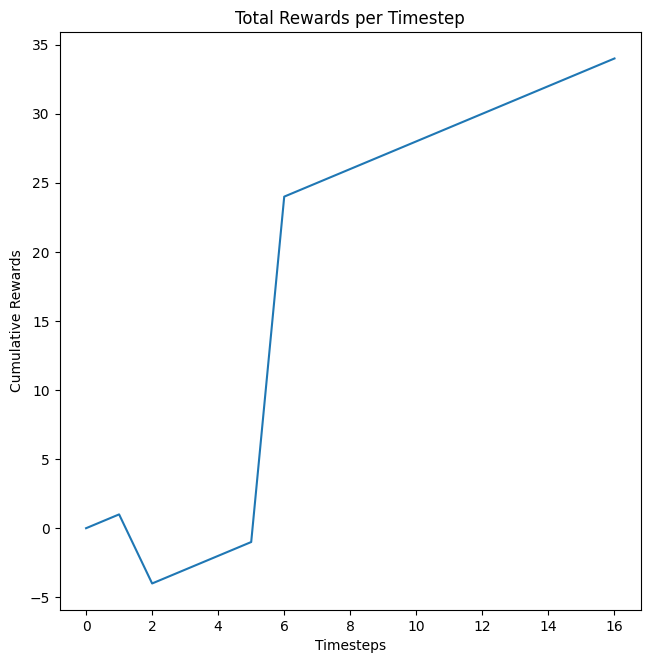


Q-Learning Table:

[[-6.500e-01  1.080e+00 -1.700e-01  0.000e+00]
 [-1.460e+00  7.400e-01 -6.000e-02  2.060e+00]
 [ 2.770e+00  4.400e-01 -2.000e-02  7.600e-01]
 [ 5.700e-01  3.000e-01 -7.000e-02  9.000e-02]
 [ 9.000e-02  5.200e-01  8.000e-02  3.330e+00]
 [ 1.990e+00  2.900e-01  6.000e-02 -3.400e-01]
 [ 4.430e+00  1.800e-01  8.000e-02 -1.000e-02]
 [ 4.000e-02  3.100e-01 -3.700e-01  3.070e+00]
 [ 1.760e+00  4.400e-01  5.000e-01  6.000e-02]
 [-5.000e-02  1.800e-01  3.700e-01 -1.000e-02]
 [ 9.700e-01  1.800e-01  8.000e-02  1.800e-01]
 [ 3.270e+00  8.000e-02  2.500e-01  1.000e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 8.000e-02  2.660e+00  1.000e-02  4.000e-02]
 [-3.000e-02  2.600e-01 -0.000e+00  2.100e-01]
 [ 7.300e-01  6.000e-02 -4.300e-01  2.200e-01]
 [ 3.900e-01  6.800e-01  1.400e-01  1.540e+00]
 [-4.000e-02  4.200e-01  1.267e+01  1.800e-01]
 [ 3.300e-01  6.600e-01  1.100e-01  8.000e-02]
 [-0.000e+00  1.800e-01  4.000e-02  2.000e-02]
 [ 8.800e+00  2.180e+00  3.740e+00  1.58

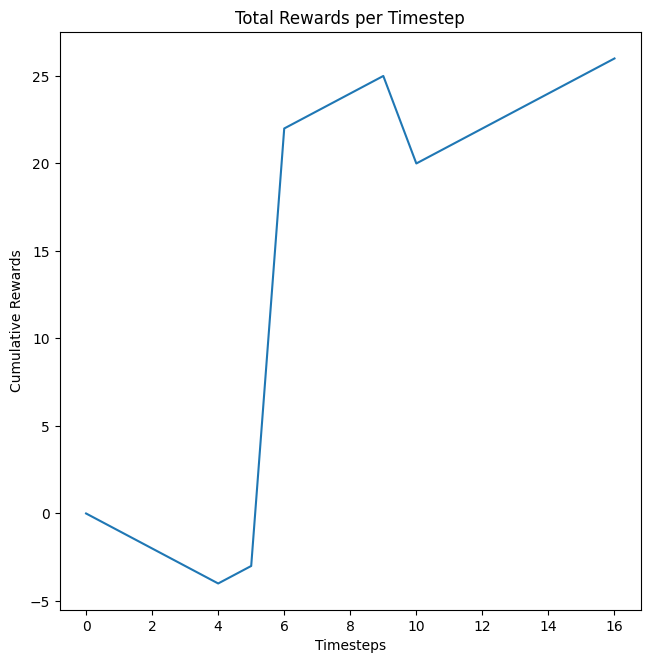


Q-Learning Table:

[[ 4.000e-02  1.980e+00 -1.900e-01  3.700e-01]
 [-1.700e-01  1.950e+00 -3.000e-02  8.300e-01]
 [ 8.600e-01  3.600e-01 -2.000e-02  2.900e+00]
 [ 7.000e-02  7.200e-01 -4.000e-02  2.400e-01]
 [-8.000e-02  8.600e-01 -8.000e-02  8.000e-02]
 [ 3.010e+00  5.700e-01  6.000e-02 -5.000e-01]
 [ 3.830e+00  6.000e-01  1.400e-01  2.600e-01]
 [ 2.320e+00  8.500e-01 -4.500e-01  1.110e+00]
 [ 4.170e+00  6.400e-01  7.400e-01  1.000e-01]
 [-1.000e-02  8.100e-01  1.000e-01  7.000e-02]
 [ 2.430e+00  6.500e-01  8.000e-02  2.200e-01]
 [ 7.890e+00  5.000e-02  1.160e+00  1.000e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 1.200e-01  1.150e+00  1.300e-01  1.000e-02]
 [-2.000e-02  1.300e-01  1.430e+00  2.500e-01]
 [ 7.800e-01  6.600e-01 -6.000e-01  2.380e+00]
 [ 7.300e-01  1.860e+00  1.260e+00  5.500e-01]
 [ 2.400e-01  5.300e-01  1.229e+01  3.700e-01]
 [ 1.940e+00  4.200e-01  1.100e-01  3.100e-01]
 [-8.000e-02  1.020e+00  1.300e-01 -2.200e-01]
 [ 1.011e+01  4.270e+00  5.360e+00  4.15

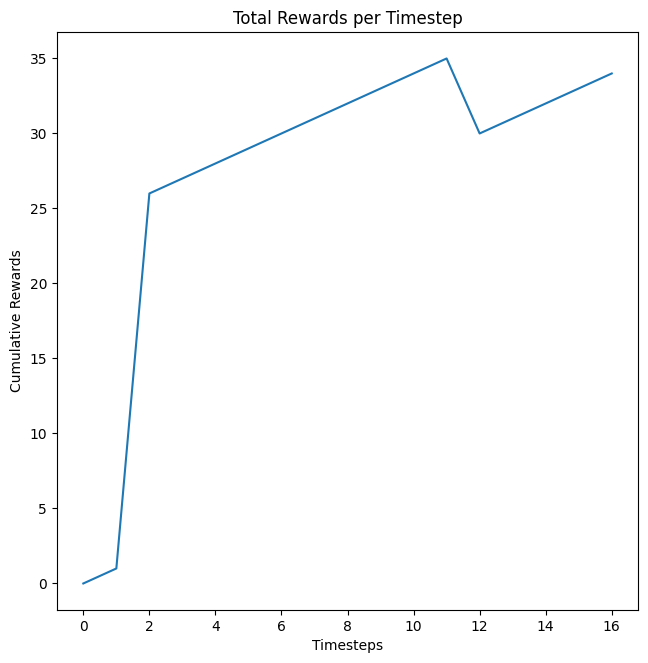

In [110]:
#Giving specific values for all the hyper parameters
for alpha in [0.1,0.15,0.2]:
    hyper_parameters = {}
    hyper_parameters['alpha'] = alpha           # Learning-rate
    hyper_parameters['max_timesteps'] = 100   #no. of timesteps per episode
    hyper_parameters['epsilon'] = 1
    hyper_parameters['Epsilon Decay'] = 1.005  #Exploration Rate  
    hyper_parameters['gamma'] = 0.8          #discount-factor
    number_of_episodes = 1000                 # No of episodes
    metrics = {}
    ql = Q_Learning_S()
    ql.train()
    print("\nQ-Learning Table:\n")
    print(ql.Q_Table)
    #Plotting all the required graphs
    ql.test(plot=False)
    plt.clf()
    plt.plot(metrics['Evaluation of Rewards'])
    plt.title("Total Rewards per Timestep")
    plt.xlabel("Timesteps")
    plt.ylabel("Cumulative Rewards")
    plt.show()

# **PART 3**

# **Solving Stock Trading Environment**

In [111]:
# Imports
import gym
from gym import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [112]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gym.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

                 info: - info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

In [113]:
#Resetting Environment to Initial state
stock_trading_environment = StockTradingEnvironment('NVDA.csv', number_of_days_to_consider=10)
stock_trading_environment.reset()

(0, None)

# **Training Using Random Policy**

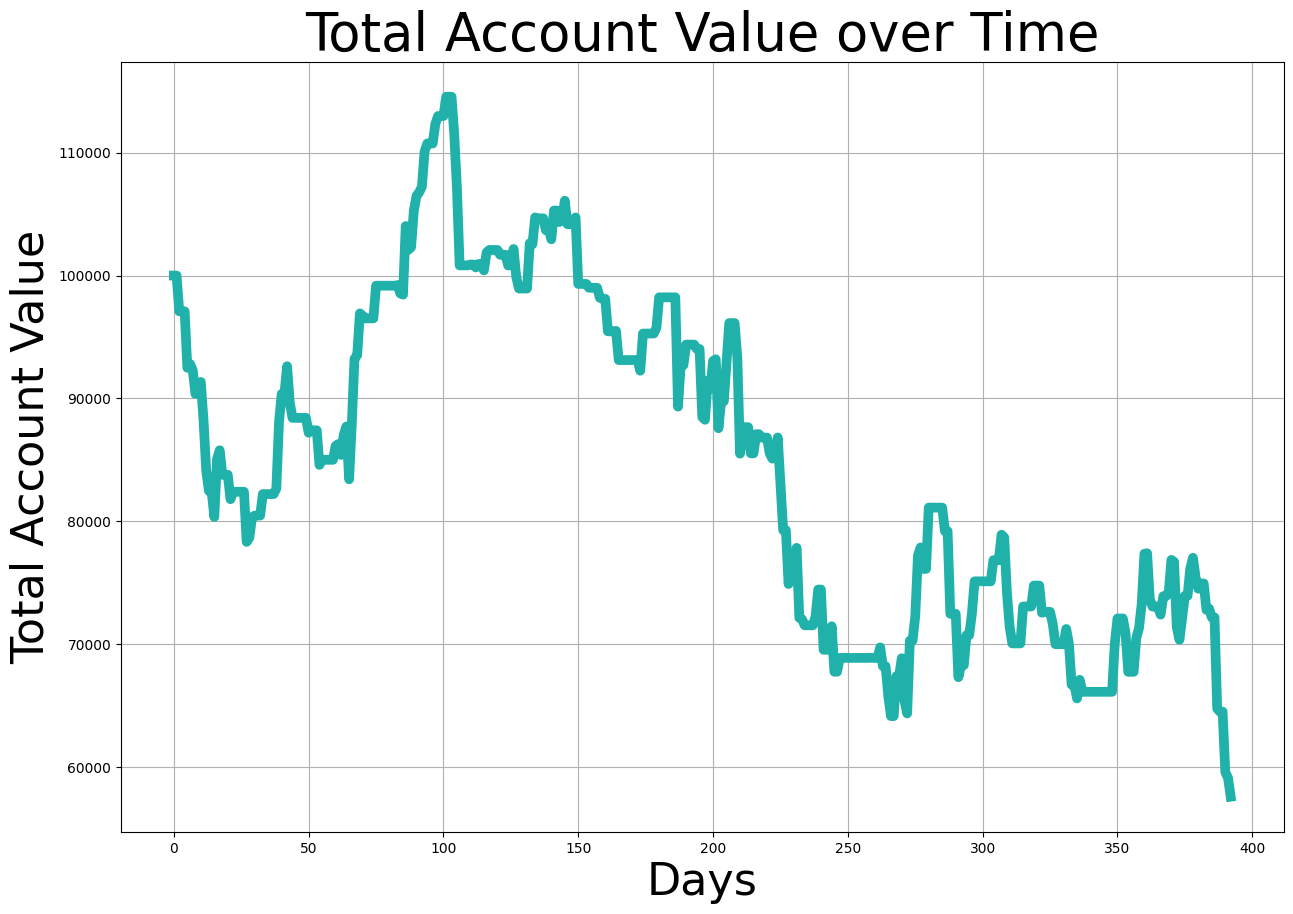

In [114]:
done = False
while not done:
    action = random.randint(0,30)%3
    observation, reward, done, truncated, info = stock_trading_environment.step(action)
stock_trading_environment.render()

# **Testing Using Random Policy**

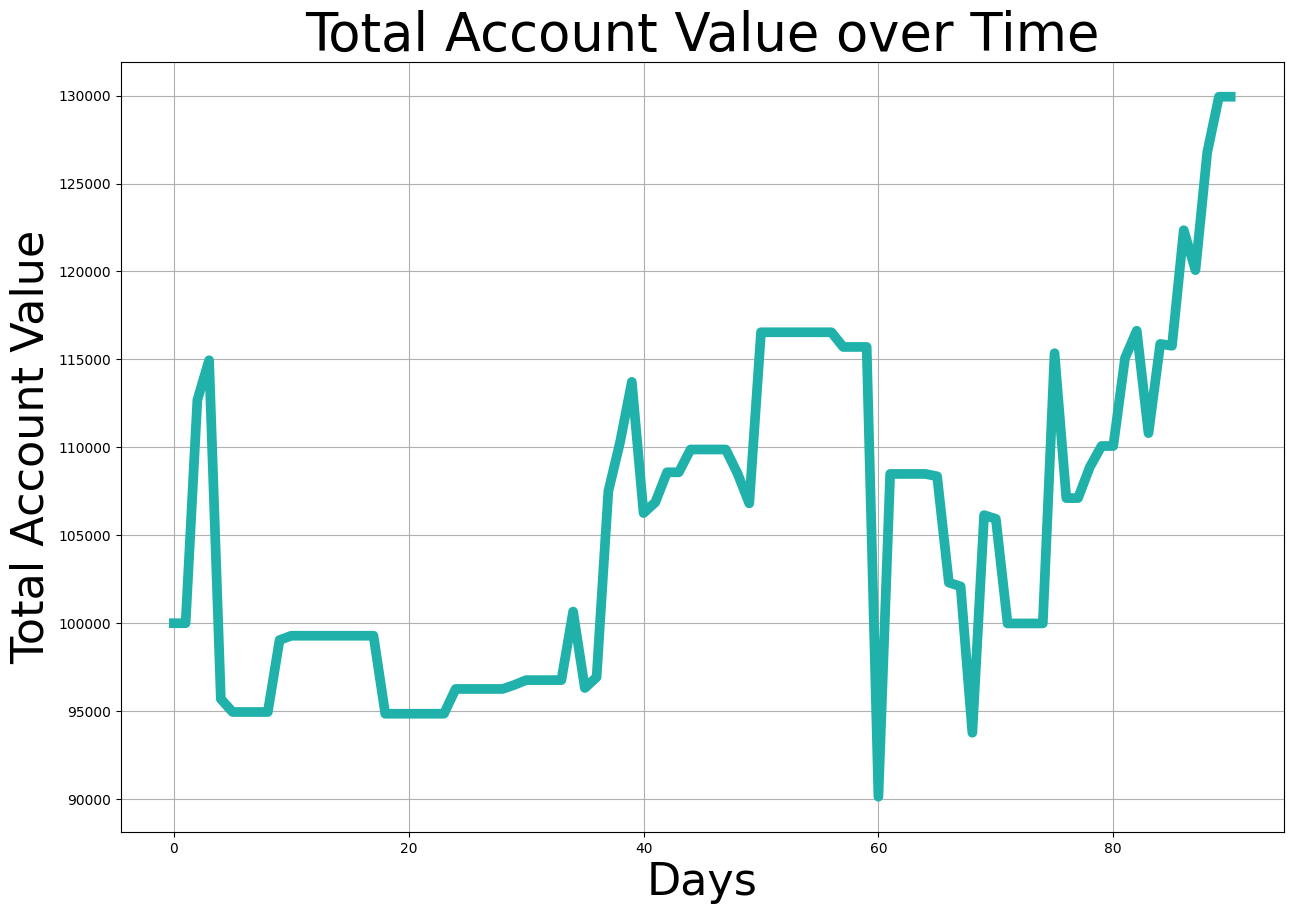

In [115]:
stock_trading_environment = StockTradingEnvironment('NVDA.csv', train=False, number_of_days_to_consider=10)
stock_trading_environment.reset()
done = False
while not done:
    action = random.randint(0,30)%3
    observation, reward, done, truncated, info = stock_trading_environment.step(action)
stock_trading_environment.render()

In [116]:
class Q_Learning_Stock_Env():
    # Off-Policy TD Control
    # Approximates the optimal action-value function independent of the policy being followed.

    def __init__(self):
        #Intialising Q table with all zeros of size 5x5
        self.Q_Table = np.zeros((4,3))
        self.a_pos=0
    
    def update_table(self,observation,action,reward,nxt_observation):
        self.Q_Table[observation,action] = round(self.Q_Table[observation,action] + hyper_parameters['alpha']*(reward + hyper_parameters['gamma']*np.max(self.Q_Table[nxt_observation,:]) - self.Q_Table[observation,action]),2)

    def train(self):
        env = StockTradingEnvironment('NVDA.csv', number_of_days_to_consider=10)
        #Setting up keys for dictionary
        metrics['Timesteps']     = []
        metrics['Total Account Value']       = []
        #metrics['Cumulative Rewards'] = []
        #Exploration Rate 
        metrics['Epsilon Decay'] = []


        #Modifying learning rate gradually
        for i in range(number_of_episodes): #number of episodes = 1000
            j = 100                         
            env.reset()
            observation=0

            #Updating learning rate gradually as the number of episodes increases
            if i%j == 0:
                hyper_parameters['alpha'] /= 10
            done = False
            while not done:

                if random.random() < hyper_parameters['epsilon']:                   #Random Policy 
                    action = random.randint(0,30)%3
                else:
                    action = np.argmax(self.Q_Table[observation,:])

                #Performing resultant action
                nxt_observation, reward, done, truncated, info = env.step(action)
                self.update_table(observation,action,reward,nxt_observation)
                observation=nxt_observation
              
            #Appending the values for their corresponding keys         
            metrics['Timesteps'].append(env.timestep)
            metrics['Total Account Value'].append(env.total_account_value)
            #metrics['Cumulative Rewards'].append(env.cumulative_rewards)
            metrics['Epsilon Decay'].append(hyper_parameters['epsilon'])
            hyper_parameters['epsilon'] /= hyper_parameters['Epsilon Decay']
              
    def execute(self):
        #Change the environment (Deterministic/Stochastic) according to the requirement while running
        print("execute")

# **Training Using Q-Learning Policy**


Q-Table:

[[19.87  5.45 14.42]
 [ 8.98 21.19 26.76]
 [15.01  3.6  12.08]
 [ 3.83 13.1  10.55]]


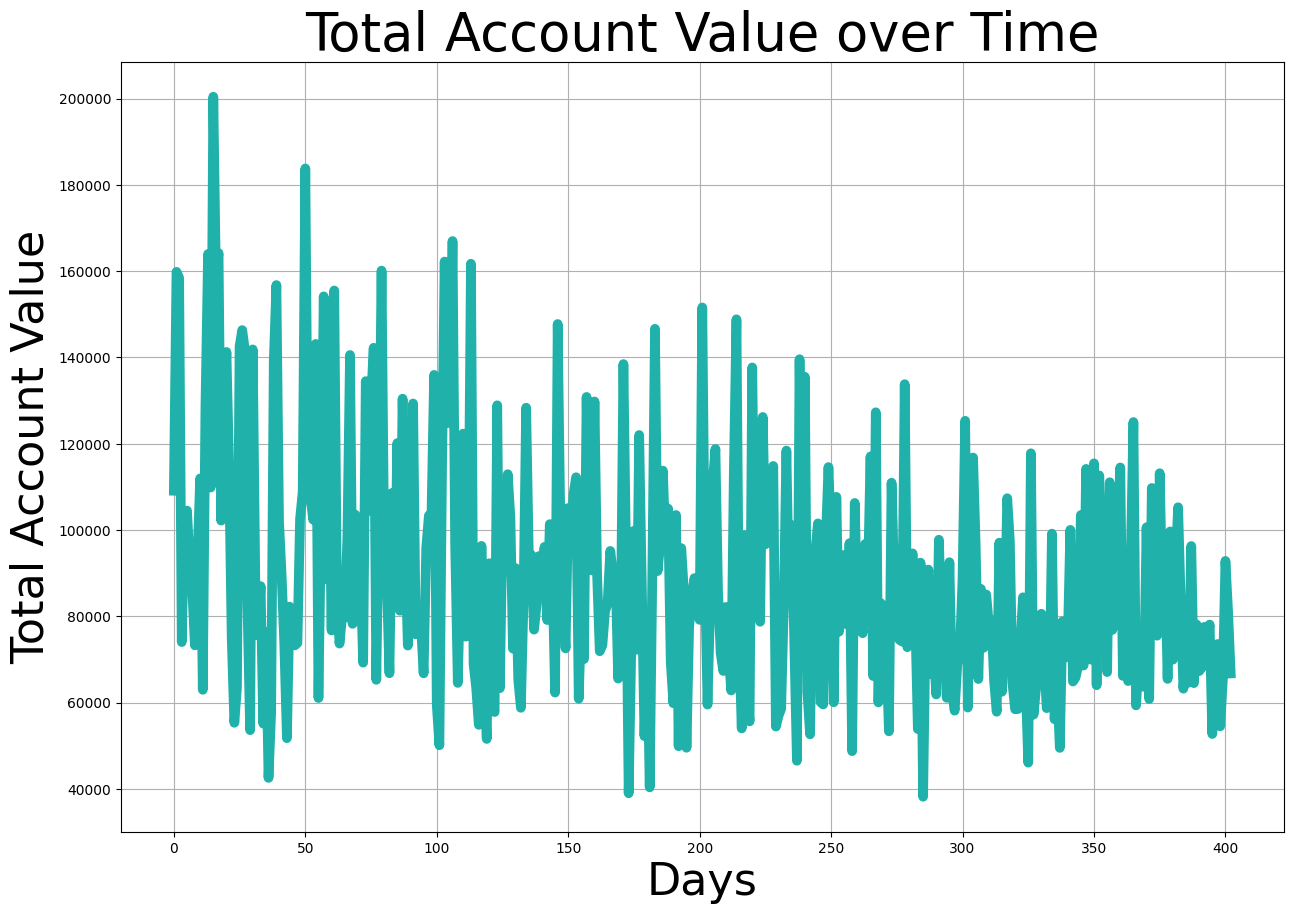

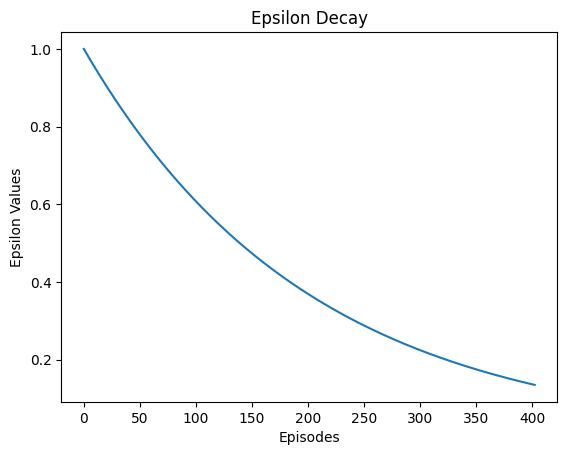

In [117]:
#Giving specific values for all the hyper parameters
hyper_parameters = {}
hyper_parameters['alpha'] = 0.2           # Learning-rate
hyper_parameters['epsilon'] = 1
hyper_parameters['Epsilon Decay'] = 1.005  #Exploration Rate  
hyper_parameters['gamma'] = 0.9          #discount-factor
number_of_episodes = 403                # No of episodes
metrics = {}
ql = Q_Learning_Stock_Env()
ql.train()
print("\nQ-Table:\n")
print(ql.Q_Table)
with open("Stock_Trading.pkl",'wb') as f:
    pickle.dump(ql.Q_Table,f)
plt.figure(figsize=(15, 10))
plt.plot(metrics['Total Account Value'], color='lightseagreen', linewidth=7)
plt.xlabel('Days', fontsize=32)
plt.ylabel('Total Account Value', fontsize=32)
plt.title('Total Account Value over Time', fontsize=38)
plt.grid()
plt.show()
plt.plot(metrics['Epsilon Decay'])
plt.title("Epsilon Decay")
plt.xlabel("Episodes")
plt.ylabel("Epsilon Values")
plt.show()

# **Testing - Choosing Optimal/Greedy Action using the above Q-Learning Table to maximize outcomes**

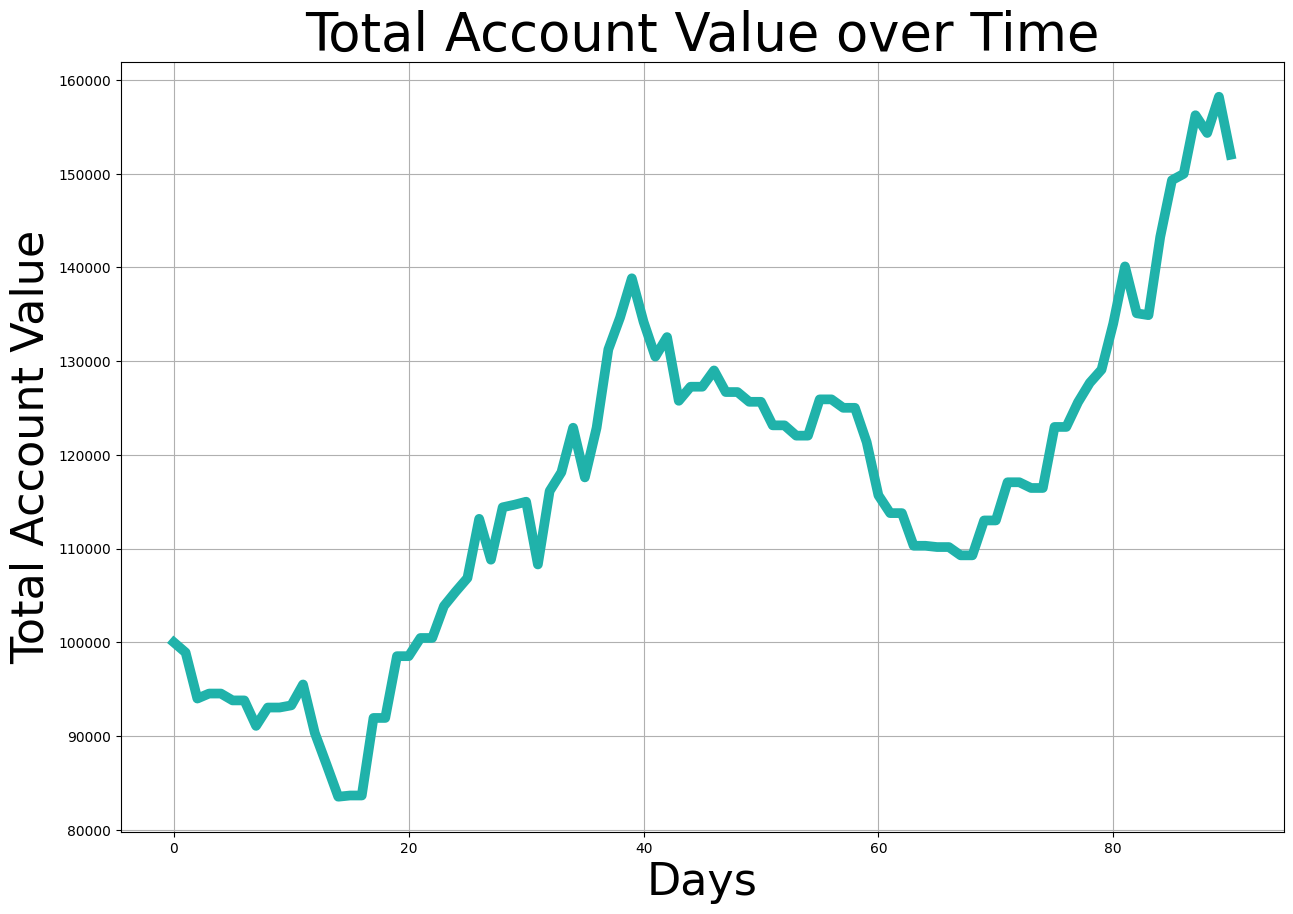

In [118]:
stock_trading_environment = StockTradingEnvironment('NVDA.csv', train=False,number_of_days_to_consider=10)
observation,info=stock_trading_environment.reset()
done = False
while not done:
    action = np.argmax(ql.Q_Table[int(observation),:])
    observation, reward, done, truncated, info = stock_trading_environment.step(action)
stock_trading_environment.render()